# Slope stability simulation impromevents

- [Config](#Config)
- [Read General Data](#Read_General_Data)
- [General Analysis](#General_Analysis)
- [Sensitivity Analysis](#Sensitivity_Analysis)
    - [Sensitivity General](#Sensitivity_Analysis_General)
    - [Sensitivity Forest](#SensitivityAnalysisForest)
    - [Sensitivity Combined Graphics](#SensitivityAnalysisGraphics)
- [Optimization](#Optimization)
- [Application](#Application)
- [Optimization Single](#Optimization_sinlge)


<a id="Config"></a>
## Config

In [1]:
import os
import glob

import math

import numpy as np
import pandas as pd
import geopandas as gpd

from osgeo import gdal
from osgeo.gdalconst import *
from osgeo.gdalnumeric import *
from osgeo_utils import gdal_calc
from osgeo import gdal_array
gdal.UseExceptions()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from matplotlib.cbook import boxplot_stats
from matplotlib.transforms import ScaledTranslation
import seaborn as sns

from itertools import combinations
import pickle


mkdir -p failed for path /home/jupyter-slc4/.cache/matplotlib: [Errno 13] Permission denied: '/home/jupyter-slc4/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-z8soo_jn because there was an issue with the default path (/home/jupyter-slc4/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import tomlkit

In [3]:
from SALib.sample.sobol import sample
from SALib.analyze import sobol
from SALib import ProblemSpec

In [4]:
from lmfit import Minimizer, Parameters, create_params, report_fit
from lmfit.model import save_modelresult


<a id="#Read_General_Data"></a>
## Read General Data 

In [5]:
input_base_path = "./data/plots"
plot_path = os.path.join(input_base_path,"plots_sensitivity.gpkg")
df_plot_sens = gpd.read_file(plot_path,engine="pyogrio", fid_as_index=True)
df_plot_sens.reset_index(inplace=True)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/tljh/user/envs/lab/share/proj failed


In [6]:
df_plot_sens.columns

Index(['fid', 'RS_ID', 'year', 'source', 'CLUSTER_ID', 'CLUSTER_SIZE',
       'ps_Area', 'ps_SL_number', 'ps_psid', 'ps_tecto', 'ps_slide_count',
       'ps_year_min', 'ps_year_max', 'ps_slide_in_forest_count',
       'ps_slope10_mean', 'ps_slope10_median', 'ps_slope10_min',
       'ps_slope10_max', 'ps_ezg_TEILEZGNR', 'ps_ezg_slide_count',
       'ps_ezg_slides_per_ha', 'width', 'height', 'area', 'perimeter',
       'slide_count', 'year_min', 'year_max', 'slide_in_forest_count',
       'slope10_mean', 'slope10_median', 'slope10_min', 'slope10_max',
       'soil_type_count', 'soil_type_min', 'soil_type_max',
       'soil_type_majority', 'geometry'],
      dtype='object')

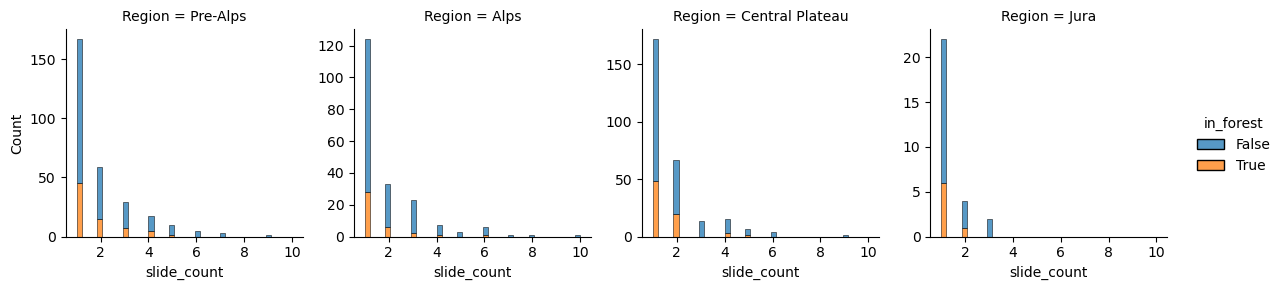

In [7]:
recs = []
for index, row in df_plot_sens.iterrows():
    if row["slide_count"]>0 and row["slide_in_forest_count"]>0 and row["slide_count"]>row["slide_in_forest_count"]:
        recs.append({"Region":row["ps_tecto"],"in_forest":False,"slide_count":row["slide_count"]-row["slide_in_forest_count"]})
    elif row["slide_count"]>0: 
        recs.append({"Region":row["ps_tecto"],"in_forest":False,"slide_count":row["slide_count"]})
    if row["slide_in_forest_count"]>0:
        recs.append({"Region":row["ps_tecto"],"in_forest":True,"slide_count":row["slide_in_forest_count"]})

df = pd.DataFrame(recs)
sns.displot(df, x="slide_count", col="Region", height=3, facet_kws=dict(sharey=False), hue="in_forest", multiple="stack")

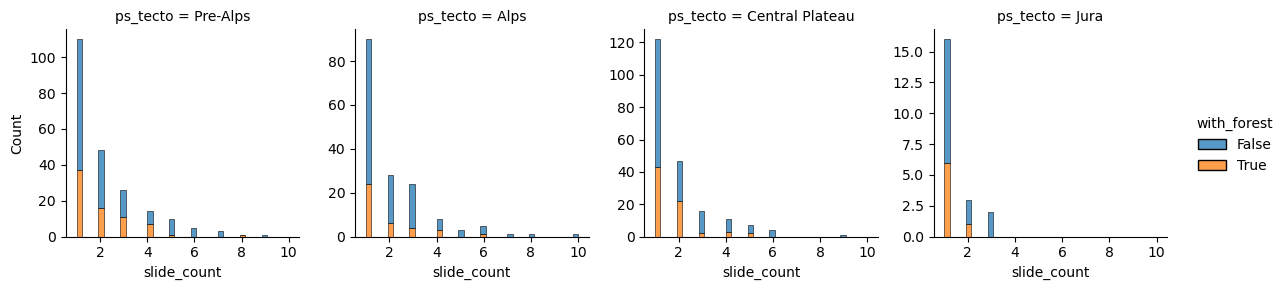

In [8]:
df_plot_sens["with_forest"] = df_plot_sens["slide_in_forest_count"]>0
sns.displot(df_plot_sens, x="slide_count", col="ps_tecto", height=3, facet_kws=dict(sharey=False), hue="with_forest", multiple="stack")


In [9]:
df_plot_sens["with_forest"] = df_plot_sens["slide_in_forest_count"]>0

In [10]:
input_base_path = "./data/plots"
plot_path = os.path.join(input_base_path,"plots_optimization.gpkg")
df_plot_opt = gpd.read_file(plot_path,engine="pyogrio", fid_as_index=True)
df_plot_opt.reset_index(inplace=True)

In [11]:
df_plot_opt.columns

Index(['fid', 'id', 'left', 'top', 'right', 'bottom', 'row_index', 'col_index',
       'psid', 'ps_Area', 'ps_SL_number', 'ps_psid', 'ps_tecto',
       'ps_slide_count', 'ps_year_min', 'ps_year_max',
       'ps_slide_in_forest_count', 'ps_slope10_mean', 'ps_slope10_median',
       'ps_slope10_min', 'ps_slope10_max', 'ps_ezg_TEILEZGNR',
       'ps_ezg_slide_count', 'ps_ezg_slides_per_ha', 'slide_count', 'year_min',
       'year_max', 'slope10_mean', 'slope10_median', 'slope10_min',
       'slope10_max', 'soil_type_count', 'soil_type_min', 'soil_type_max',
       'soil_type_majority', 'noslide_count', 'geometry'],
      dtype='object')

In [12]:
psid_sensitivity = df_plot_sens["ps_psid"].tolist()

In [13]:
optimization_base_path = "./data/optimization/expert_default"

plot_records = []

for folder_name in next(os.walk(optimization_base_path))[1]:
    plot_path = os.path.join(optimization_base_path,folder_name)
    plot_id = int(folder_name.replace("plot_",""))
    toml_template_path = os.path.join(plot_path,"default_config.toml")
    with open(toml_template_path, mode="rt") as fp:
        config = tomlkit.load(fp)
        
        perimeter_cell_count = config["perimeter_cell_count"] 
        forest_cell_count = config["forest_cell_count"] 
        plot_sensitivity = config["plot_sensitivity"] 
        plot_slide_count = config["slide_count"]
        plot_forest_slide_count = config["slide_in_forest_count"]
        if plot_sensitivity:
            tecto = df_plot_sens[df_plot_sens["ps_psid"]==plot_id].iloc[0]["ps_tecto"]
        else:
            tecto = df_plot_opt[df_plot_opt["ps_psid"]==plot_id].iloc[0]["ps_tecto"]
        
        plot_records.append({"psid":plot_id,"region":tecto,"perimeter_cell_count":perimeter_cell_count,"forest_cell_count":forest_cell_count,"plot_sensitivity":plot_sensitivity,"forest_pct":forest_cell_count/perimeter_cell_count,"slide_count":plot_slide_count,"forest_slide_count":plot_forest_slide_count})

plot_stat_df = pd.DataFrame(plot_records)
plot_stat_df["is_forest_plot"] = plot_stat_df["forest_pct"]>=0.5
plot_stat_df

psid           region  perimeter_cell_count  forest_cell_count  \
0      6028         Pre-Alps                  2704                  0   
1     13893  Central Plateau                  2809               1343   
2      9797             Alps                  2704               2587   
3     14072  Central Plateau                  2809               2299   
4     19448             Jura                  2704                  0   
...     ...              ...                   ...                ...   
1211  20007             Jura                  2704                  0   
1212    380             Alps                  2704                  0   
1213   3107             Alps                  2809               2366   
1214   9976         Pre-Alps                  2809                  3   
1215  16185  Central Plateau                  2809               2651   

      plot_sensitivity  forest_pct  slide_count  forest_slide_count  \
0                False    0.000000            0                   0   
1                 True    0.478106            1                   0   
2                False    0.956731            0                   0   
3                 True    0.818441            2                   2   
4                False    0.000000            0                   0   
...                ...         ...          ...                 ...   
1211             False    0.000000            0                   0   
1212             False    0.000000            0                   0   
1213              True    0.842293            1                   1   
1214              True    0.001068            2                   0   
1215              True    0.943752            1                   1   

      is_forest_plot  
0              False  
1              False  
2               True  
3               True  
4              False  
...              ...  
1211           False  
1212           False  
1213            True  
1214           False  
1215            True  

[1216 rows x 9 columns]

<a id="#General_Analysis"></a>
## General Analysis


In [14]:
print(len(plot_stat_df[plot_stat_df["plot_sensitivity"]]))
plot_stat_df[plot_stat_df["plot_sensitivity"]].groupby(by=["region"])["psid"].count()

608


region
Alps               161
Central Plateau    208
Jura                21
Pre-Alps           218
Name: psid, dtype: int64

In [15]:
print(len(plot_stat_df[plot_stat_df["plot_sensitivity"] & plot_stat_df["is_forest_plot"]]))
plot_stat_df[plot_stat_df["plot_sensitivity"] & plot_stat_df["is_forest_plot"]].groupby(by=["region"])["psid"].count()

214


region
Alps               58
Central Plateau    72
Jura                5
Pre-Alps           79
Name: psid, dtype: int64

In [16]:

print(len(plot_stat_df[np.invert(plot_stat_df["plot_sensitivity"])]))
plot_stat_df[np.invert(plot_stat_df["plot_sensitivity"])].groupby(by=["region"])["psid"].count()

608


region
Alps               172
Central Plateau    223
Jura                99
Pre-Alps           114
Name: psid, dtype: int64

In [17]:

print(len(plot_stat_df[np.invert(plot_stat_df["plot_sensitivity"])  & plot_stat_df["is_forest_plot"]]))
plot_stat_df[np.invert(plot_stat_df["plot_sensitivity"])  & plot_stat_df["is_forest_plot"]].groupby(by=["region"])["psid"].count()

292


region
Alps               83
Central Plateau    95
Jura               62
Pre-Alps           52
Name: psid, dtype: int64

<a id="#Sensitivity_Analysis"></a>
## Sensitivity Analysis


<a id="#Sensitivity_Analysis_General"></a>
### Sensitivity General

In [18]:
input_base_path = "./data/sensitivity/general"
sobol_parameters_path = os.path.join(input_base_path,"sensitivity_param_values.txt")

combination_path = os.path.join(input_base_path,"combination_merged_reduced.csv")


In [19]:
df_params = pd.read_csv(sobol_parameters_path,sep=" ",names= ["c_mean", "fc_mean", "ks_mean", "por_mean", "r_mean","rainfall"])
df_params.head()


c_mean   fc_mean      ks_mean  por_mean     r_mean  rainfall
0  4.556454  0.131748  4980.246932  0.739256  31.923341  4.933577
1  3.769169  0.131748  4980.246932  0.739256  31.923341  4.933577
2  4.556454  0.108660  4980.246932  0.739256  31.923341  4.933577
3  4.556454  0.131748  2323.616811  0.739256  31.923341  4.933577
4  4.556454  0.131748  4980.246932  0.490081  31.923341  4.933577

In [20]:
df_combination = pd.read_csv(combination_path,sep=";")

print(len(df_combination))


8716288


In [21]:
df_combination.head()

i  plot_fid  ls_failed
0  0       266        0.0
1  0       313        0.0
2  0       355        0.0
3  0       370        0.0
4  0       394        0.0

In [22]:
num_sim = len(df_params)
num_sim

14336

In [23]:
df_combination["plot_fid"] = df_combination["plot_fid"].astype("int32")
df_combination["i"] = df_combination["i"].astype("int32")
df_combination = df_combination.sort_values(["i","plot_fid"])

df_combination.head()


i  plot_fid  ls_failed
0  0       266        0.0
1  0       313        0.0
2  0       355        0.0
3  0       370        0.0
4  0       394        0.0

In [24]:
problem = {
    "num_vars": 6,
    "names": ["c_mean", "fc_mean", "ks_mean", "por_mean", "r_mean","rainfall"],
    "bounds": [[0, 5], # cohesion
               [0.1, 0.36], # field capacity
               [0.000864, 8640], #transmissivity ks
               [0.30,0.60], # porosity
               [20, 45], # internal angle of friction r
               [0.1, 5], # maybe add significantly higher maximum 
               ]
}

# Read parameter values from simulation input
param_values = np.loadtxt(sobol_parameters_path) 



In [25]:
df_comb_transposed = df_combination.pivot(index=["i"], columns="plot_fid", values=["ls_failed"])
x = df_combination["plot_fid"].unique()
y = df_comb_transposed.to_numpy().T

In [26]:
print(np.shape(param_values))
print(np.shape(x))
print(np.shape(y))


(14336, 6)
(608,)
(608, 14336)


In [27]:
sp = ProblemSpec(problem)
sp.set_results(y.T)
sp.analyze_sobol(print_to_console=False,seed=100000)


/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise

Outputs:
	608 outputs: ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29', 'Y30', 'Y31', 'Y32', 'Y33', 'Y34', 'Y35', 'Y36', 'Y37', 'Y38', 'Y39', 'Y40', 'Y41', 'Y42', 'Y43', 'Y44', 'Y45', 'Y46', 'Y47', 'Y48', 'Y49', 'Y50', 'Y51', 'Y52', 'Y53', 'Y54', 'Y55', 'Y56', 'Y57', 'Y58', 'Y59', 'Y60', 'Y61', 'Y62', 'Y63', 'Y64', 'Y65', 'Y66', 'Y67', 'Y68', 'Y69', 'Y70', 'Y71', 'Y72', 'Y73', 'Y74', 'Y75', 'Y76', 'Y77', 'Y78', 'Y79', 'Y80', 'Y81', 'Y82', 'Y83', 'Y84', 'Y85', 'Y86', 'Y87', 'Y88', 'Y89', 'Y90', 'Y91', 'Y92', 'Y93', 'Y94', 'Y95', 'Y96', 'Y97', 'Y98', 'Y99', 'Y100', 'Y101', 'Y102', 'Y103', 'Y104', 'Y105', 'Y106', 'Y107', 'Y108', 'Y109', 'Y110', 'Y111', 'Y112', 'Y113', 'Y114', 'Y115', 'Y116', 'Y117', 'Y118', 'Y119', 'Y120', 'Y121', 'Y122', 'Y123', 'Y124', 'Y125', 'Y126', 'Y127', 'Y128', 'Y129', 'Y130', 'Y131', 'Y132', 'Y133', 'Y134', 'Y135', 'Y13

In [28]:
y_vars = df_comb_transposed.apply(lambda x: np.var(x),axis=0)
y_vars_sum = np.sum(y_vars)
y_vars_sum
len(y_vars)

Su_agg = {}

su = {"S1","ST"}

for u in su:
    sus = np.array([sp.analysis[k][u] for k in sp.analysis])
    susc  = np.array([sp.analysis[k][u+"_conf"] for k in sp.analysis])
    for i in range(len(sp["names"])):
        name = sp["names"][i]        
        if name in Su_agg:
            sus_agg = Su_agg[name]
        else:
            sus_agg = {"param":name}
    
        
        sut = sus[:,i]*y_vars
        sui_agg = np.sum(sut)/y_vars_sum
        sus_agg[u+"_uncorrected"] = sui_agg

        positive_or_plausible_zero = True
        sut = np.copy(sus[:,i])
        sutc = np.copy(susc[:,i])
        for j in range(len(sut)):
            test = True if sut[j]>0 else (True if (sut[j]-abs(sutc[j]))<=0 and (sut[j]+abs(sutc[j]))>=0 else False )
            positive_or_plausible_zero = positive_or_plausible_zero and test
            if sut[j]<0 and test:
                sut[j]=0
            elif sut[j]<0:
                print(j,sut[j],sutc[j])
        sus_agg[u+"_check"] = positive_or_plausible_zero

        sut = sut*y_vars
        sui_agg = np.sum(sut)/y_vars_sum
        sus_agg[u] = sui_agg

        Su_agg[name] = sus_agg      
    

u = "S2"
names = sp["names"]
combs = list(combinations(names, 2))
for cmb in combs:
    name = " ".join(cmb)
    i0 = names.index(cmb[0])
    i1 = names.index(cmb[1])

    if name in Su_agg:
        s2_agg = Su_agg[name]
    else:
        s2_agg = {"param":name}
    
    sus = [sp.analysis[ky][u][i0][i1] for ky in sp.analysis.keys()]

    sut = sus*y_vars
    sui_agg = np.sum(sut)/y_vars_sum
    s2_agg[u+"_uncorrected"] = sui_agg

    positive_or_plausible_zero = True
    sut = [sp.analysis[ky][u][i0][i1] for ky in sp.analysis.keys()]
    sutc = [sp.analysis[ky][u+"_conf"][i0][i1] for ky in sp.analysis.keys()]    
    for j in range(len(sut)):
        test = True if sut[j]>0 else (True if (sut[j]-abs(sutc[j]))<=0 and (sut[j]+abs(sutc[j]))>=0 else False )
        positive_or_plausible_zero = positive_or_plausible_zero and test
        if sut[j]<0 and test:
            sut[j]=0
        elif sut[j]<0:
            print(j,sut[j],sutc[j])
            
    
    s2_agg[u+"_check"] = positive_or_plausible_zero

    sut = sut*y_vars
    sui_agg = np.sum(sut)/y_vars_sum
    s2_agg[u] = sui_agg


    Su_agg[name] = s2_agg   


Su_agg

399 -0.5563720752932142 0.545269146067324
445 -0.15989217545297185 0.09577932313193127
184 -0.07822173837760199 0.07760850850842865
348 -0.19442689391858628 0.1881630997786463
399 -0.15657108330400712 0.1425949182133095
445 -0.11602135444828855 0.10432986125213334
59 -0.004548045416580299 0.0037396662819715147
464 -3.1049719564114897e-06 2.9367853680748094e-06
445 -3.797218756593701 3.63144652689534
464 -8.796255048881982 8.319789513097374
591 -5.303362881856813 5.032756422083684
445 -3.6782018082450514 3.517510936329915
464 -8.787781461902556 8.311774913736853
591 -5.255165152881861 4.987063725133479
445 -3.8797554142607718 3.7104593605955007
464 -8.827728371948421 8.349558025007878
591 -5.316751139905412 5.045448846769685
464 -0.007329404813488257 0.006932393952384946
7 -0.018692927281561696 0.018280088756364783
435 -0.007737998345853159 0.007306391035002981
445 -0.052200634569172 0.04803076216099616
464 -0.024970810943845678 0.023618220466509778
558 -0.022318581322495337 0.018402144

{'c_mean': {'param': 'c_mean',
  'ST_uncorrected': 0.708941351087297,
  'ST_check': True,
  'ST': 0.708941351087297,
  'S1_uncorrected': 0.339209904102129,
  'S1_check': False,
  'S1': 0.33940730929947016},
 'fc_mean': {'param': 'fc_mean',
  'ST_uncorrected': 0.004336038614034821,
  'ST_check': True,
  'ST': 0.004336038614034821,
  'S1_uncorrected': -0.00025471271756413483,
  'S1_check': True,
  'S1': 0.00047386309059377655},
 'ks_mean': {'param': 'ks_mean',
  'ST_uncorrected': 0.020736654979297303,
  'ST_check': True,
  'ST': 0.020736654979297303,
  'S1_uncorrected': 0.005020572609032635,
  'S1_check': True,
  'S1': 0.005201071608112903},
 'por_mean': {'param': 'por_mean',
  'ST_uncorrected': 0.0724739280627078,
  'ST_check': True,
  'ST': 0.0724739280627078,
  'S1_uncorrected': 0.006649176963530658,
  'S1_check': True,
  'S1': 0.007837458564031365},
 'r_mean': {'param': 'r_mean',
  'ST_uncorrected': 0.6217579319269648,
  'ST_check': True,
  'ST': 0.6217579319269648,
  'S1_uncorrected

In [29]:
Su_agg_df = pd.DataFrame(Su_agg.values())
Su_agg_df["param"] = Su_agg_df["param"].apply(lambda x: x.replace("_mean"," "))
Su_agg_df

param  ST_uncorrected ST_check        ST  S1_uncorrected S1_check  \
0              c         0.708941     True  0.708941        0.339210    False   
1             fc         0.004336     True  0.004336       -0.000255     True   
2             ks         0.020737     True  0.020737        0.005021     True   
3            por         0.072474     True  0.072474        0.006649     True   
4              r         0.621758     True  0.621758        0.239091    False   
5        rainfall        0.006569     True  0.006569        0.002115     True   
6          c  fc              NaN      NaN       NaN             NaN      NaN   
7          c  ks              NaN      NaN       NaN             NaN      NaN   
8         c  por              NaN      NaN       NaN             NaN      NaN   
9           c  r              NaN      NaN       NaN             NaN      NaN   
10    c  rainfall             NaN      NaN       NaN             NaN      NaN   
11        fc  ks              NaN      NaN       NaN             NaN      NaN   
12       fc  por              NaN      NaN       NaN             NaN      NaN   
13         fc  r              NaN      NaN       NaN             NaN      NaN   
14   fc  rainfall             NaN      NaN       NaN             NaN      NaN   
15       ks  por              NaN      NaN       NaN             NaN      NaN   
16         ks  r              NaN      NaN       NaN             NaN      NaN   
17   ks  rainfall             NaN      NaN       NaN             NaN      NaN   
18        por  r              NaN      NaN       NaN             NaN      NaN   
19  por  rainfall             NaN      NaN       NaN             NaN      NaN   
20    r  rainfall             NaN      NaN       NaN             NaN      NaN   

          S1  S2_uncorrected S2_check        S2  
0   0.339407             NaN      NaN       NaN  
1   0.000474             NaN      NaN       NaN  
2   0.005201             NaN      NaN       NaN  
3   0.007837             NaN      NaN       NaN  
4   0.239178             NaN      NaN       NaN  
5   0.002171             NaN      NaN       NaN  
6        NaN       -0.000060     True  0.005169  
7        NaN        0.010749     True  0.012492  
8        NaN        0.023233     True  0.024946  
9        NaN        0.314770     True  0.314770  
10       NaN        0.001588     True  0.006122  
11       NaN        0.005297     True  0.005323  
12       NaN        0.004864     True  0.004883  
13       NaN        0.004650    False  0.004895  
14       NaN        0.005303     True  0.005327  
15       NaN       -0.001957    False  0.002421  
16       NaN       -0.000545    False  0.002080  
17       NaN       -0.003034    False  0.001949  
18       NaN        0.017049    False  0.017517  
19       NaN       -0.005936    False  0.002521  
20       NaN        0.003254     True  0.007634

[Text(0.5, 23.52222222222222, ''), Text(50.722222222222214, 0.5, 'Parameter')]

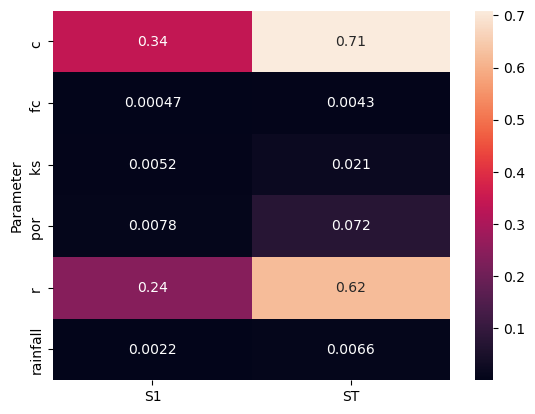

In [30]:
mlt = pd.melt(Su_agg_df.loc[np.invert(np.isnan(Su_agg_df["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
pvt = mlt.pivot(index="param", columns="variable",values="value")
ax = sns.heatmap(pvt, annot=True)
ax.set(xlabel="",ylabel="Parameter")

[Text(0.5, 23.52222222222222, ''),
 Text(50.72222222222221, 0.5, 'Parameter combination')]

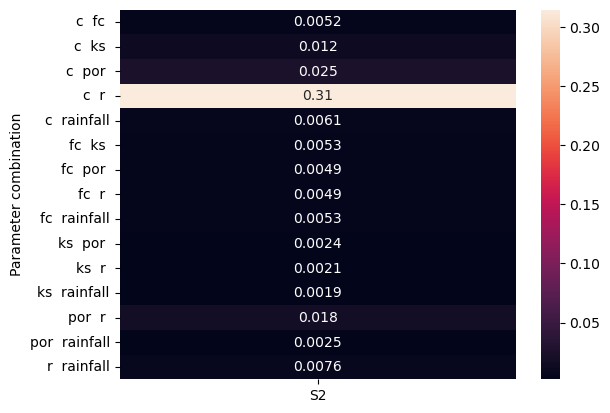

In [31]:
mlt = pd.melt(Su_agg_df.loc[np.invert(np.isnan(Su_agg_df["S2"]))], id_vars=["param"], value_vars=["S2"])
pvt = mlt.pivot(index="param", columns="variable",values="value")
ax = sns.heatmap(pvt, annot=True)
ax.set(xlabel="",ylabel="Parameter combination")


<a id="#SensitivityAnalysisForest"></a>
### Sensitivity Forest

In [32]:
input_base_path = "./data/sensitivity/forest/"
sobol_parameters_path = os.path.join(input_base_path,"sensitivity_param_values_with_forest.txt")

combination_path = os.path.join(input_base_path,"combination_forest_merged_reduced.csv")
# sample_path = os.path.join(input_base_path,"sample_merged.csv")


In [33]:
df_params = pd.read_csv(sobol_parameters_path,sep=" ",names= ["c_mean", "fc_mean", "ks_mean", "por_mean", "r_mean","rainfall","forest"])
df_params.head()


c_mean   fc_mean      ks_mean  por_mean     r_mean  rainfall  forest
0  2.778874  0.372585  4643.229948  0.741520  31.235957  0.882515     1.0
1  1.936388  0.372585  4643.229948  0.741520  31.235957  0.882515     1.0
2  2.778874  0.294469  4643.229948  0.741520  31.235957  0.882515     1.0
3  2.778874  0.372585  4276.451407  0.741520  31.235957  0.882515     1.0
4  2.778874  0.372585  4643.229948  0.364004  31.235957  0.882515     1.0

In [34]:
df_combination = pd.read_csv(combination_path,sep=";")

print(len(df_combination))

df_combination.head()


3506176


i  plot_fid  ls_failed_forest
0  0       313               0.0
1  0       394               0.0
2  0       398               0.0
3  0       500               0.0
4  0       531               0.0

In [35]:
num_sim = len(df_params)
num_sim

16384

In [36]:
df_combination["plot_fid"] = df_combination["plot_fid"].astype("int32")
df_combination["i"] = df_combination["i"].astype("int32")
df_combination = df_combination.sort_values(["i","plot_fid"])


df_combination.head()


i  plot_fid  ls_failed_forest
0  0       313               0.0
1  0       394               0.0
2  0       398               0.0
3  0       500               0.0
4  0       531               0.0

In [37]:
problem = {
    "num_vars": 7,
    "names": ["c_mean", "fc_mean", "ks_mean", "por_mean", "r_mean","rainfall","forest"],
    "bounds": [[0, 5], # cohesion
               [0.1, 0.4], # field capacity
               [0.000864, 8640], #transmissivity ks
               [0.25,0.75], # porosity
               [20, 45], # internal angle of friction r
               [0.1, 5], # maybe add significantly higher maximum 
               [0,1], # simulate with forest or not
               ]
}
# Generate parmeter values using the sobol.sample function
param_values = sample(problem, 1024)

# Read parameter values from simulation input
param_values = np.loadtxt(sobol_parameters_path) 



In [38]:
df_comb_transposed = df_combination.pivot(index=["i"], columns="plot_fid", values=["ls_failed_forest"])
x = df_combination["plot_fid"].unique()
y = df_comb_transposed.to_numpy().T

In [39]:
print(np.shape(param_values))
print(np.shape(x))
print(np.shape(y))


(16384, 7)
(214,)
(214, 16384)


In [40]:
sp = ProblemSpec(problem)
sp.set_results(y.T)
sp.analyze_sobol(print_to_console=False,seed=100000)


/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/opt/tljh/user/envs/lab/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise

Outputs:
	214 outputs: ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29', 'Y30', 'Y31', 'Y32', 'Y33', 'Y34', 'Y35', 'Y36', 'Y37', 'Y38', 'Y39', 'Y40', 'Y41', 'Y42', 'Y43', 'Y44', 'Y45', 'Y46', 'Y47', 'Y48', 'Y49', 'Y50', 'Y51', 'Y52', 'Y53', 'Y54', 'Y55', 'Y56', 'Y57', 'Y58', 'Y59', 'Y60', 'Y61', 'Y62', 'Y63', 'Y64', 'Y65', 'Y66', 'Y67', 'Y68', 'Y69', 'Y70', 'Y71', 'Y72', 'Y73', 'Y74', 'Y75', 'Y76', 'Y77', 'Y78', 'Y79', 'Y80', 'Y81', 'Y82', 'Y83', 'Y84', 'Y85', 'Y86', 'Y87', 'Y88', 'Y89', 'Y90', 'Y91', 'Y92', 'Y93', 'Y94', 'Y95', 'Y96', 'Y97', 'Y98', 'Y99', 'Y100', 'Y101', 'Y102', 'Y103', 'Y104', 'Y105', 'Y106', 'Y107', 'Y108', 'Y109', 'Y110', 'Y111', 'Y112', 'Y113', 'Y114', 'Y115', 'Y116', 'Y117', 'Y118', 'Y119', 'Y120', 'Y121', 'Y122', 'Y123', 'Y124', 'Y125', 'Y126', 'Y127', 'Y128', 'Y129', 'Y130', 'Y131', 'Y132', 'Y133', 'Y134', 'Y135', 'Y13

In [41]:
y_vars = df_comb_transposed.apply(lambda x: np.var(x),axis=0)
y_vars_sum = np.sum(y_vars)
y_vars_sum
len(y_vars)

Su_f_agg = {}

su = {"S1","ST"}

for u in su:
    sus = np.array([sp.analysis[k][u] for k in sp.analysis])
    susc  = np.array([sp.analysis[k][u+"_conf"] for k in sp.analysis])
    for i in range(len(sp["names"])):
        name = sp["names"][i]        
        if name in Su_f_agg:
            sus_agg = Su_f_agg[name]
        else:
            sus_agg = {"param":name}
    
        
        sut = sus[:,i]*y_vars
        sui_agg = np.sum(sut)/y_vars_sum
        sus_agg[u+"_uncorrected"] = sui_agg

        positive_or_plausible_zero = True
        sut = np.copy(sus[:,i])
        sutc = np.copy(susc[:,i])
        for j in range(len(sut)):
            test = True if sut[j]>0 else (True if (sut[j]-abs(sutc[j]))<=0 and (sut[j]+abs(sutc[j]))>=0 else False )
            positive_or_plausible_zero = positive_or_plausible_zero and test
            if sut[j]<0 and test:
                sut[j]=0
            elif sut[j]<0:
                print(j,sut[j],sutc[j])
        sus_agg[u+"_check"] = positive_or_plausible_zero

        sut = sut*y_vars
        sui_agg = np.sum(sut)/y_vars_sum
        sus_agg[u] = sui_agg

        Su_f_agg[name] = sus_agg      
    

u = "S2"
names = sp["names"]
combs = list(combinations(names, 2))
for cmb in combs:
    name = " ".join(cmb)
    i0 = names.index(cmb[0])
    i1 = names.index(cmb[1])

    if name in Su_f_agg:
        s2_agg = Su_f_agg[name]
    else:
        s2_agg = {"param":name}
    
    sus = [sp.analysis[ky][u][i0][i1] for ky in sp.analysis.keys()]

    sut = sus*y_vars
    sui_agg = np.sum(sut)/y_vars_sum
    s2_agg[u+"_uncorrected"] = sui_agg

    positive_or_plausible_zero = True
    sut = [sp.analysis[ky][u][i0][i1] for ky in sp.analysis.keys()]
    sutc = [sp.analysis[ky][u+"_conf"][i0][i1] for ky in sp.analysis.keys()]    
    for j in range(len(sut)):
        test = True if sut[j]>0 else (True if (sut[j]-abs(sutc[j]))<=0 and (sut[j]+abs(sutc[j]))>=0 else False )
        positive_or_plausible_zero = positive_or_plausible_zero and test
        if sut[j]<0 and test:
            sut[j]=0
        elif sut[j]<0:
            print(j,sut[j],sutc[j])
            
    
    s2_agg[u+"_check"] = positive_or_plausible_zero

    sut = sut*y_vars
    sui_agg = np.sum(sut)/y_vars_sum
    s2_agg[u] = sui_agg


    Su_f_agg[name] = s2_agg   

Su_f_agg

108 -0.015585078841115407 0.014635326018997634
158 -0.011894267315018022 0.009836196906264829
174 -0.021132248546902075 0.017261635466033654
183 -0.01093568318497528 0.010566901617178638
103 -0.02503480160676491 0.024743720875281424
132 -0.019363829927355025 0.01872268759809876
135 -0.0060671280239921604 0.005995832865694937
160 -0.006965762476726117 0.0068739636161184395
174 -0.02657057044718951 0.02094264606553633
158 -0.010662727632778432 0.009773125154378373
174 -0.022872525015076306 0.018697636230310028
183 -0.011271179701250217 0.011111852690538302
158 -0.012351439784143856 0.010910128229716978
174 -0.019707022129000766 0.019575135602545552
56 -0.0020022552027301943 0.0019190939139497592


{'c_mean': {'param': 'c_mean',
  'ST_uncorrected': 0.6831929001998168,
  'ST_check': True,
  'ST': 0.6831929001998168,
  'S1_uncorrected': 0.3397097706425004,
  'S1_check': True,
  'S1': 0.3397097706425004},
 'fc_mean': {'param': 'fc_mean',
  'ST_uncorrected': 0.004406090836946242,
  'ST_check': True,
  'ST': 0.004406090836946242,
  'S1_uncorrected': -0.001455695054664867,
  'S1_check': True,
  'S1': 0.0002504818234804106},
 'ks_mean': {'param': 'ks_mean',
  'ST_uncorrected': 0.014774370896583788,
  'ST_check': True,
  'ST': 0.014774370896583788,
  'S1_uncorrected': 0.010234437002132083,
  'S1_check': True,
  'S1': 0.010236214231994261},
 'por_mean': {'param': 'por_mean',
  'ST_uncorrected': 0.0798962000449962,
  'ST_check': True,
  'ST': 0.0798962000449962,
  'S1_uncorrected': 0.014992945718998759,
  'S1_check': True,
  'S1': 0.01549617684550369},
 'r_mean': {'param': 'r_mean',
  'ST_uncorrected': 0.5478962162064039,
  'ST_check': True,
  'ST': 0.5478962162064039,
  'S1_uncorrected': 

In [42]:
Su_f_agg_df = pd.DataFrame(Su_f_agg.values())
Su_f_agg_df["param"] = Su_f_agg_df["param"].apply(lambda x: x.replace("_mean"," "))

Su_f_agg_df

param  ST_uncorrected ST_check        ST  S1_uncorrected  \
0                c         0.683193     True  0.683193        0.339710   
1               fc         0.004406     True  0.004406       -0.001456   
2               ks         0.014774     True  0.014774        0.010234   
3              por         0.079896     True  0.079896        0.014993   
4                r         0.547896     True  0.547896        0.232582   
5          rainfall        0.004166     True  0.004166        0.001460   
6            forest        0.119229     True  0.119229        0.023388   
7            c  fc              NaN      NaN       NaN             NaN   
8            c  ks              NaN      NaN       NaN             NaN   
9           c  por              NaN      NaN       NaN             NaN   
10            c  r              NaN      NaN       NaN             NaN   
11      c  rainfall             NaN      NaN       NaN             NaN   
12        c  forest             NaN      NaN       NaN             NaN   
13          fc  ks              NaN      NaN       NaN             NaN   
14         fc  por              NaN      NaN       NaN             NaN   
15           fc  r              NaN      NaN       NaN             NaN   
16     fc  rainfall             NaN      NaN       NaN             NaN   
17       fc  forest             NaN      NaN       NaN             NaN   
18         ks  por              NaN      NaN       NaN             NaN   
19           ks  r              NaN      NaN       NaN             NaN   
20     ks  rainfall             NaN      NaN       NaN             NaN   
21       ks  forest             NaN      NaN       NaN             NaN   
22          por  r              NaN      NaN       NaN             NaN   
23    por  rainfall             NaN      NaN       NaN             NaN   
24      por  forest             NaN      NaN       NaN             NaN   
25      r  rainfall             NaN      NaN       NaN             NaN   
26        r  forest             NaN      NaN       NaN             NaN   
27  rainfall forest             NaN      NaN       NaN             NaN   

   S1_check        S1  S2_uncorrected S2_check        S2  
0      True  0.339710             NaN      NaN       NaN  
1      True  0.000250             NaN      NaN       NaN  
2      True  0.010236             NaN      NaN       NaN  
3      True  0.015496             NaN      NaN       NaN  
4      True  0.232582             NaN      NaN       NaN  
5      True  0.001700             NaN      NaN       NaN  
6      True  0.023933             NaN      NaN       NaN  
7       NaN       NaN        0.020530     True  0.022222  
8       NaN       NaN        0.015510     True  0.017697  
9       NaN       NaN        0.028774     True  0.030031  
10      NaN       NaN        0.253068     True  0.253068  
11      NaN       NaN        0.018616     True  0.020503  
12      NaN       NaN        0.063112     True  0.063389  
13      NaN       NaN        0.000667     True  0.001200  
14      NaN       NaN        0.000897     True  0.001224  
15      NaN       NaN        0.000214     True  0.001094  
16      NaN       NaN        0.000453     True  0.001088  
17      NaN       NaN        0.001086     True  0.001370  
18      NaN       NaN       -0.003349    False  0.000630  
19      NaN       NaN       -0.006380    False  0.000065  
20      NaN       NaN       -0.003107    False  0.000921  
21      NaN       NaN       -0.003045    False  0.000777  
22      NaN       NaN        0.022647     True  0.022666  
23      NaN       NaN       -0.001654     True  0.001531  
24      NaN       NaN       -0.000847     True  0.002495  
25      NaN       NaN        0.016040     True  0.017291  
26      NaN       NaN        0.041541     True  0.043234  
27      NaN       NaN       -0.001655    False  0.000457

[Text(0.5, 23.52222222222222, ''), Text(50.722222222222214, 0.5, 'Parameter')]

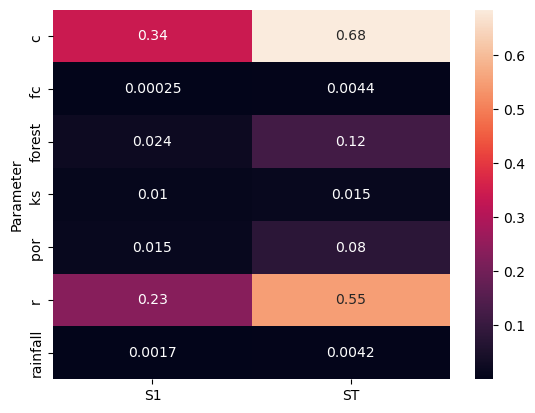

In [43]:
mlt = pd.melt(Su_f_agg_df.loc[np.invert(np.isnan(Su_f_agg_df["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
pvt = mlt.pivot(index="param", columns="variable",values="value")
ax = sns.heatmap(pvt, annot=True)
ax.set(xlabel="",ylabel="Parameter")

[Text(0.5, 23.52222222222222, ''),
 Text(50.72222222222221, 0.5, 'Parameter combination')]

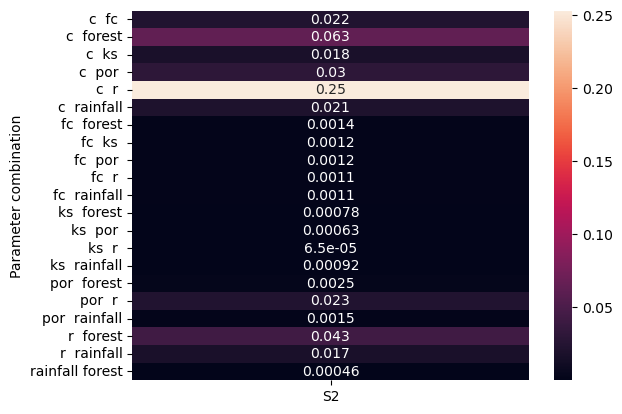

In [44]:
mlt = pd.melt(Su_f_agg_df.loc[np.invert(np.isnan(Su_f_agg_df["S2"]))], id_vars=["param"], value_vars=["S2"])
pvt = mlt.pivot(index="param", columns="variable",values="value")
ax = sns.heatmap(pvt, annot=True)
ax.set(xlabel="",ylabel="Parameter combination")


<a id="#SensitivityAnalysisGraphics"></a>
### Sensitivity Combined Graphics

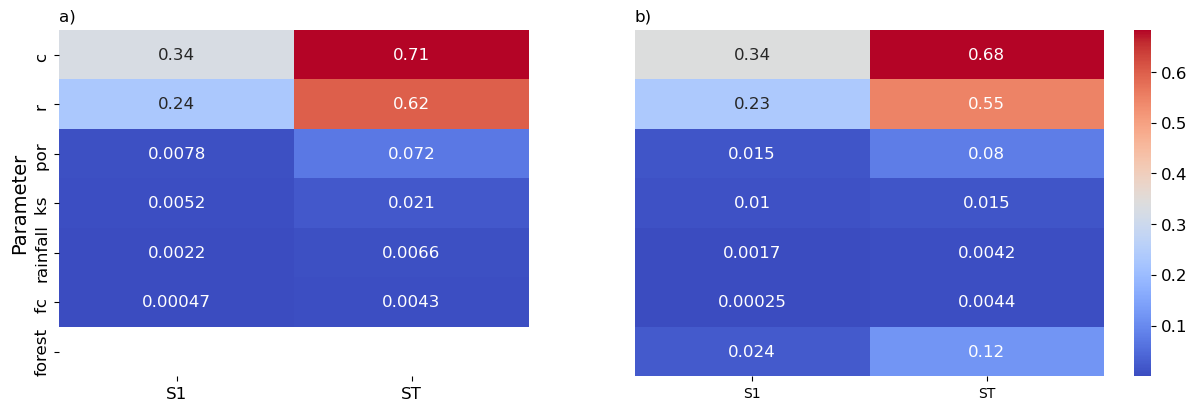

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1, 1.25], figsize=[15,4.5])
# fig.suptitle("Sensitivity Analysis")

font_size_default = plt.rcParams.get("font.size")
font_size = 12
plt.rcParams.update({"font.size": font_size})

cmap = "coolwarm"

mlt = pd.melt(Su_agg_df.loc[np.invert(np.isnan(Su_agg_df["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
mlt = pd.concat([mlt,pd.DataFrame([{"param":"forest","variable":"S1","value":NaN},{"param":"forest","variable":"ST","value":NaN},])])
pvt = mlt.pivot(index="param", columns="variable",values="value")
pvt = pvt.sort_values(by=["S1"],ascending=False)

g1 = sns.heatmap(pvt, annot=True, cbar=False, ax=ax1, cmap = cmap)
g1.set_ylabel("Parameter",fontsize=font_size+2)
g1.set_xlabel("",fontsize=font_size)
ax1.set_title("a)", fontfamily='sans-serif', loc='left', fontsize='medium')
ax1.tick_params(labelsize=font_size)

mlt = pd.melt(Su_f_agg_df.loc[np.invert(np.isnan(Su_f_agg_df["S1"]))], id_vars=["param"], value_vars=["S1","ST"])
pvt2 = mlt.pivot(index="param", columns="variable",values="value")
idx = pvt.index.array.tolist()
pvt2.sort_index( key=lambda x: [idx.index(y) for y in x.array.tolist() ], inplace=True)

g2 = sns.heatmap(pvt2, annot=True, ax=ax2, cmap = cmap)
g2.set(xlabel="",ylabel="")
g2.set_yticks([])
ax2.set_title("b)", fontfamily='sans-serif', loc='left', fontsize='medium')

plt.rcParams.update({"font.size": font_size_default})

fig.savefig("fig4.png", dpi=600) 
fig.savefig("fig4.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
fig.savefig("fig4.eps", dpi=600) 



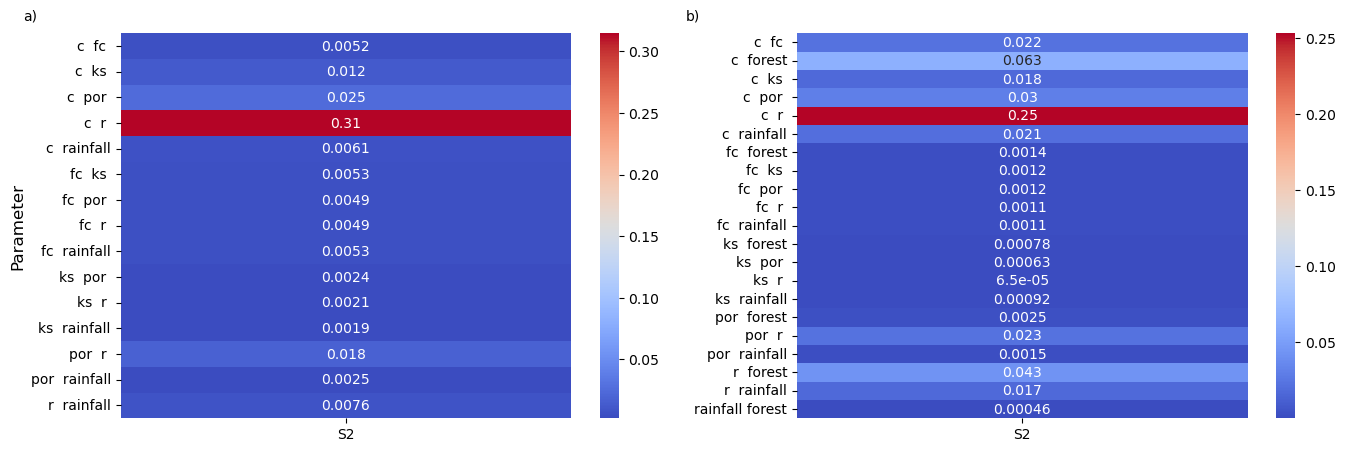

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1, 1], figsize=[16,5])
# fig.suptitle("Sensitivity Analysis")

font_size_default = plt.rcParams.get("font.size")
font_size = 10
plt.rcParams.update({"font.size": font_size})

cmap = "coolwarm"

mlt = pd.melt(Su_agg_df.loc[np.invert(np.isnan(Su_agg_df["S2"]))], id_vars=["param"], value_vars=["S2"])
pvt = mlt.pivot(index="param", columns="variable",values="value")
# pvt = pvt.sort_values(by=["S2"],ascending=False)

g1 = sns.heatmap(pvt, annot=True, cbar=True, ax=ax1, cmap = cmap)
g1.set_ylabel("Parameter",fontsize=font_size+2)
g1.set_xlabel("",fontsize=font_size)
ax1.text( 0.0, 1.0, "a)", transform=(ax1.transAxes + ScaledTranslation(-70/72, +7/72, fig.dpi_scale_trans)), fontsize='medium', va='bottom', fontfamily='sans-serif')
# ax1.set_title("a)", fontfamily='serif', loc='left', fontsize='medium')

mlt = pd.melt(Su_f_agg_df.loc[np.invert(np.isnan(Su_f_agg_df["S2"]))], id_vars=["param"], value_vars=["S2"])
pvt2 = mlt.pivot(index="param", columns="variable",values="value")
# idx = pvt.index.array.tolist()
# pvt2.sort_index( key=lambda x: [idx.index(y) for y in x.array.tolist() ], inplace=True)

g2 = sns.heatmap(pvt2, annot=True, ax=ax2, cmap = cmap)
g2.set(xlabel="",ylabel="")
# g2.set_yticks([])
ax2.text( 0.0, 1.0, "b)", transform=(ax2.transAxes + ScaledTranslation(-80/72, +7/72, fig.dpi_scale_trans)), fontsize='medium', va='bottom', fontfamily='sans-serif')
# ax2.set_title("b)", fontfamily='serif', loc='left', fontsize='medium')

plt.rcParams.update({"font.size": font_size_default})

fig.savefig("fig9.png", dpi=600) 
fig.savefig("fig9.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
fig.savefig("fig9.eps", dpi=600) 



<a id="#Optimization"></a>
## Optimization

Looking at a single optimization run at a time.

In [47]:
# Expert input initial values for comparison
optimization_base_path = "./data/optimization/expert_default"
csv_path = os.path.join(optimization_base_path,"optimization_merged_1.csv")
iteration = 1
opt_initial_df = pd.read_csv(csv_path)
opt_initial_df = opt_initial_df.iloc[:,1:]
opt_initial_df["iteration"] = iteration

opt_initial_df["sensitivity"] = opt_initial_df["plot_fid"].apply(lambda x: x in psid_sensitivity)
opt_initial_df["Group"] = opt_initial_df["sensitivity"].apply(lambda x: "With landslides" if x else "Without landslides")
opt_initial_df["state"] = "Initial (Expert input)"

In [48]:
# Path to optimization to be analyzed
optimization_base_path = "./data/optimization/minimum_0_1"

In [49]:
opt_dfs = []

for csv_path in glob.glob(os.path.join(optimization_base_path,"optimization_merged_*.csv")):
    csv_name = os.path.basename(csv_path)
    iteration = int(csv_name.replace("optimization_merged_","").replace(".csv",""))
    optt_df = pd.read_csv(csv_path)
    optt_df = optt_df.iloc[:,1:]
    optt_df["iteration"] = iteration
    opt_dfs.append(optt_df)
    
opt_df = pd.concat(opt_dfs)


In [50]:
opt_df["sensitivity"] = opt_df["plot_fid"].apply(lambda x: x in psid_sensitivity)

In [51]:
soil_properties_dfs = []

for csv_path in glob.glob(os.path.join(optimization_base_path,"SoilProperties_*.csv")):
    csv_name = os.path.basename(csv_path)
    iteration = int(csv_name.replace("SoilProperties_","").replace(".csv",""))
    spt_df = pd.read_csv(csv_path)
    spt_df["iteration"] = iteration
    soil_properties_dfs.append(spt_df)
    
soil_properties_df = pd.concat(soil_properties_dfs)
soil_properties_df = soil_properties_df.sort_values(["Soil Name","iteration"])



In [52]:
pickle_path = os.path.join(optimization_base_path,"model_fit_reslt.pkl")
with open(pickle_path, 'rb') as f:
    result = pickle.load(f)


[Text(0.5, 0, 'iteration'),
 Text(0, 0.5, 'Sum of Squares (1-AUC)'),
 Text(0.5, 1.0, './data/optimization/minimum_0_1')]

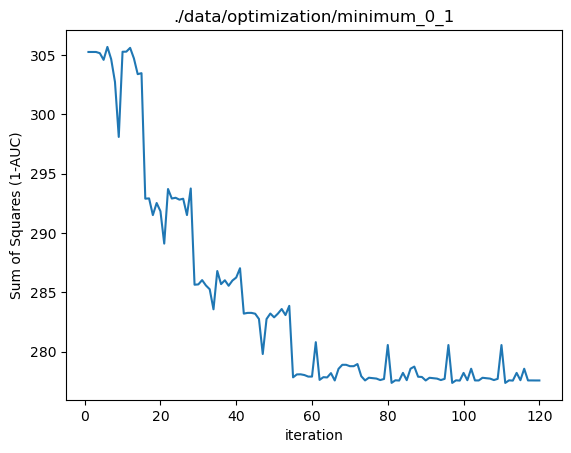

In [53]:
# opt_agg = opt_df.groupby(by="i").agg(lambda x: math.sqrt(x.pow(2).sum()))
opt_agg = opt_df.groupby(by="i").agg(lambda x: x.pow(2).sum())
opt_agg.reset_index(inplace=True)

ax = sns.lineplot(data=opt_agg,x="i",y="res")
ax.set(xlabel="iteration",ylabel="Sum of Squares (1-AUC)",title=optimization_base_path)

[Text(0.5, 0, 'iteration'),
 Text(0, 0.5, 'Sum of Squares AUC'),
 Text(0.5, 1.0, './data/optimization/minimum_0_1')]

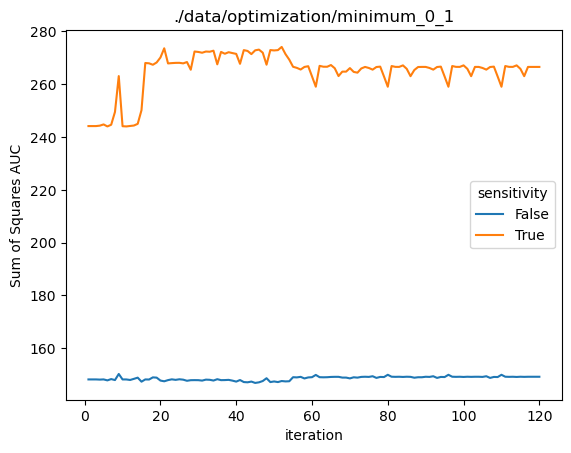

In [54]:
opt_agg = opt_df.groupby(by=["i","sensitivity"]).agg(lambda x: x.pow(2).sum())
opt_agg.reset_index(inplace=True)

ax = sns.lineplot(data=opt_agg,x="i",y="auc",hue="sensitivity")
ax.set(xlabel="iteration",ylabel="Sum of Squares AUC",title=optimization_base_path)

[Text(0.5, 0, 'iteration'),
 Text(0, 0.5, 'Sum of Squares (1-AUC)'),
 Text(0.5, 1.0, './data/optimization/minimum_0_1')]

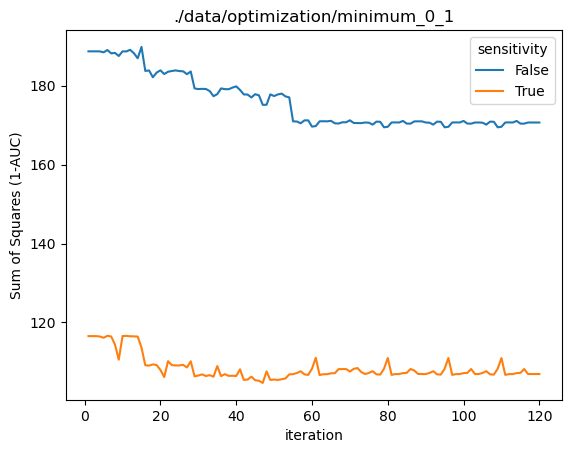

In [55]:
opt_agg = opt_df.groupby(by=["i","sensitivity"]).agg(lambda x: x.pow(2).sum())
opt_agg.reset_index(inplace=True)

ax = sns.lineplot(data=opt_agg,x="i",y="res",hue="sensitivity")
ax.set(xlabel="iteration",ylabel="Sum of Squares (1-AUC)",title=optimization_base_path)

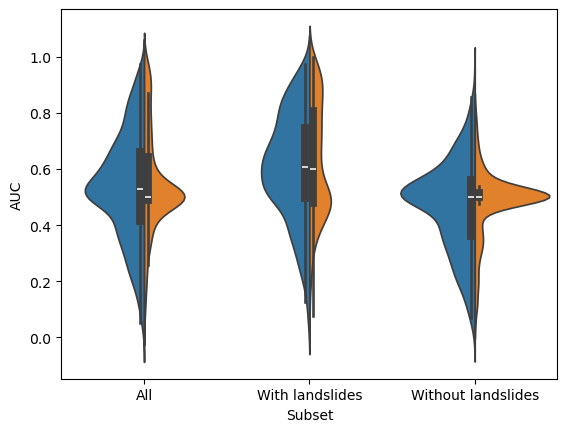

In [56]:
opt_df2 = opt_df.loc[(opt_df["i"]==1) | (opt_df["i"]==opt_df["i"].max())].reset_index()
opt_df2["state"] = opt_df2["i"].apply(lambda x: "Initial" if x==1 else "Optimised")
opt_df2["Group"] = opt_df2["sensitivity"].apply(lambda x: "With landslides" if x else "Without landslides")
opt_df3 = opt_df2.copy()
opt_df3["Group"] = "All"
opt_df3 =pd.concat([opt_df2,opt_df3])
opt_df3 =  opt_df3.sort_values(by=["Group","state"], ascending=True)

ax = sns.violinplot(opt_df3,x="Group", y="auc", hue=opt_df3["state"], zorder=2, split=True, width=0.9)
ax.set(xlabel="Subset",ylabel="AUC")
ax.get_legend().set_visible(False)

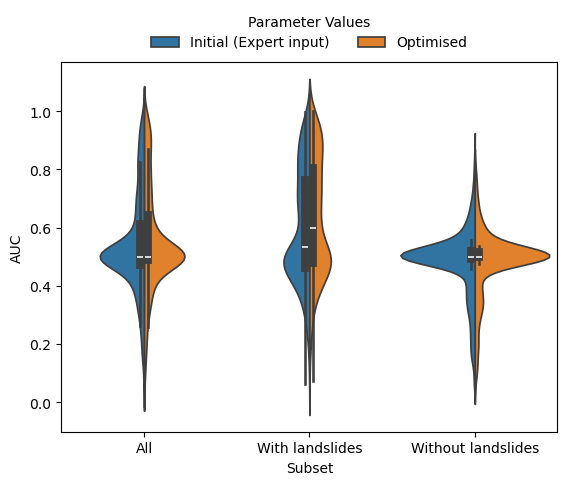

In [57]:
opt_end_df = opt_df.loc[(opt_df["i"]==opt_df["i"].max())].reset_index()
opt_end_df["state"] = "Optimised"
opt_end_df["Group"] = opt_end_df["sensitivity"].apply(lambda x: "With landslides" if x else "Without landslides")

opt_df2 = pd.concat([opt_initial_df,opt_end_df])

opt_df3 = opt_df2.copy()
opt_df3["Group"] = "All"
opt_df3 =pd.concat([opt_df2,opt_df3])

opt_df3 =  opt_df3.sort_values(by=["Group","state"], ascending=True)

ax = sns.violinplot(opt_df3,x="Group", y="auc", hue=opt_df3["state"], zorder=2, split=True, width=0.9)
ax.set(xlabel="Subset",ylabel="AUC")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title="Parameter Values", frameon=False)


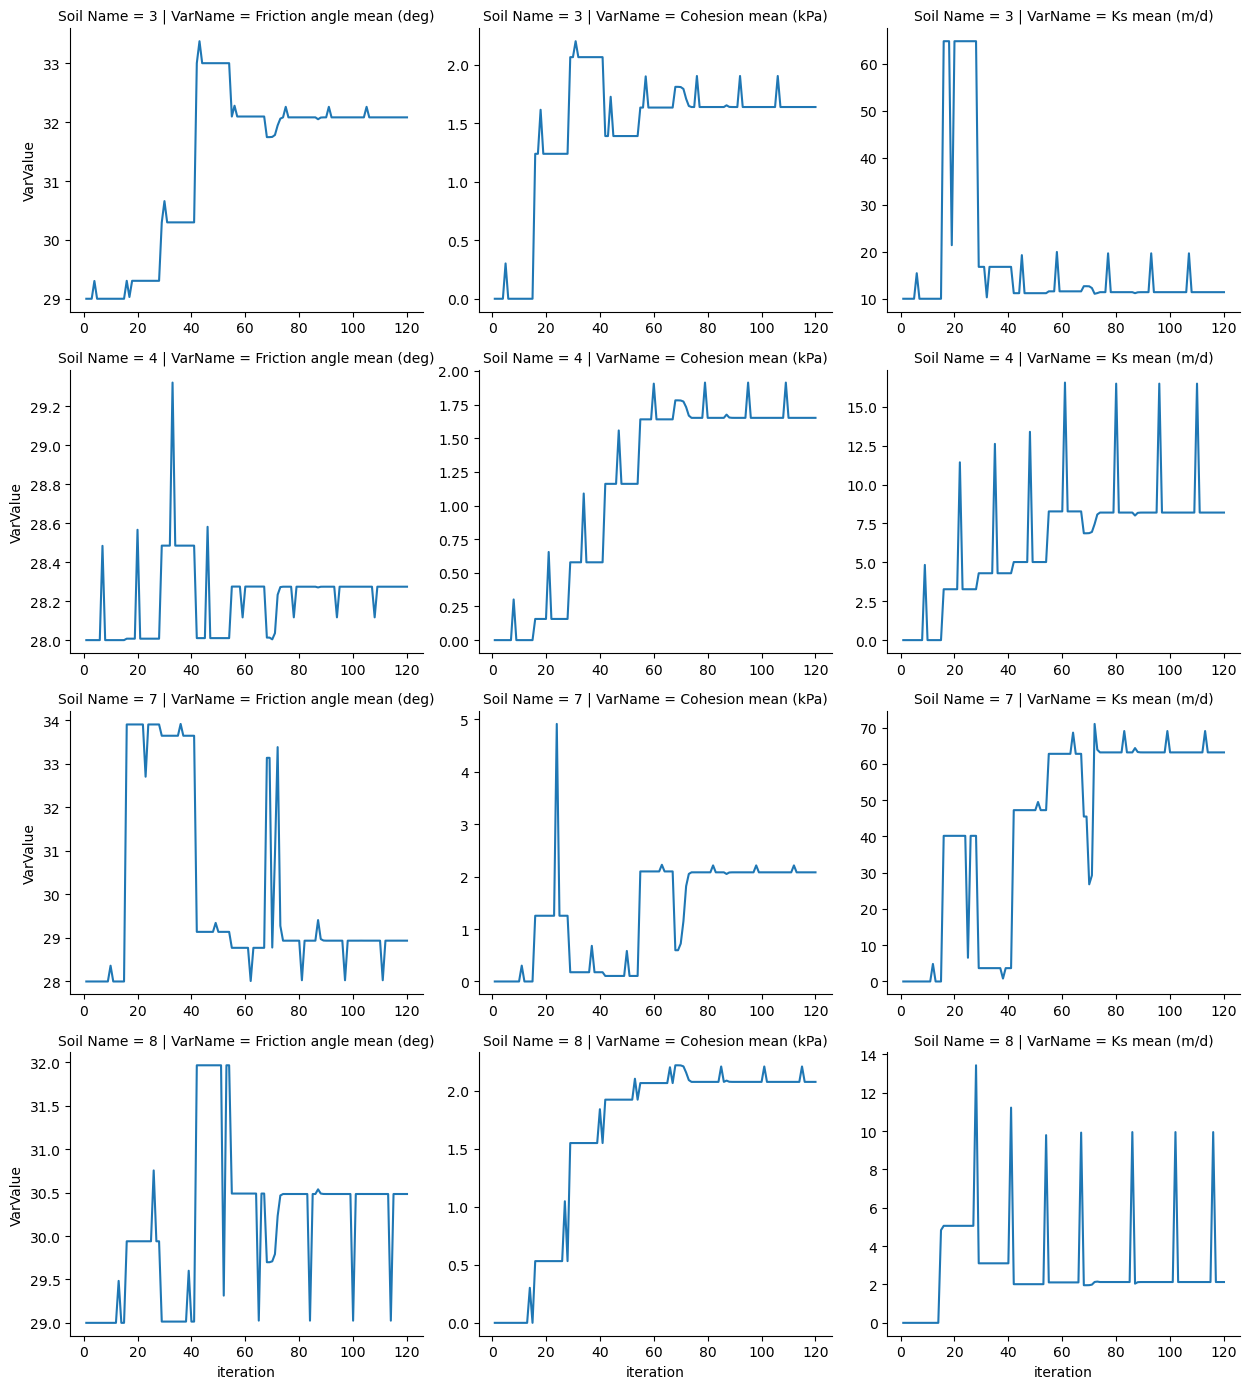

In [58]:
# Changed in parameter values
soil_properties_df_melt = pd.melt(soil_properties_df[soil_properties_df["Soil Name"].isin([3,4,7,8])], id_vars=["Soil Name", "iteration"], value_vars=["Friction angle mean (deg)", "Cohesion mean (kPa)","Ks mean (m/d)"], var_name="VarName", value_name="VarValue")
g = sns.FacetGrid(soil_properties_df_melt, col="VarName", row="Soil Name", sharey=False, sharex=False, height=3.5, aspect=1.2)

g.map(sns.lineplot, "iteration", "VarValue")

In [59]:
ssq_res_start = opt_df[opt_df["i"]==opt_df["i"].min()]["res"].pow(2).sum()
ssq_res_end = opt_df[opt_df["i"]==opt_df["i"].max()]["res"].pow(2).sum()
ssq_auc_start = opt_df[opt_df["i"]==opt_df["i"].min()]["auc"].pow(2).sum()
ssq_auc_end = opt_df[opt_df["i"]==opt_df["i"].max()]["auc"].pow(2).sum()

print(ssq_res_start)
print(ssq_res_end)
print(ssq_auc_start)
print(ssq_auc_end)

305.2417631030781
277.58109776986237
392.35603379207686
415.7635304372578


In [60]:
result

Analyze the optimization runs in combination

In [61]:
optimization_parameters = dict(        
        r_3 = dict(label = "Friction mean", value=34, soil_type = 3, delta=0.5, min=29, max=34, vary=True), c_3 = dict(label = "Cohesion mean", value=0.5, soil_type = 3, delta=0.5, min=0, max=5, vary=True), ks_3 = dict(label = "Transmissivity mean", value=20, soil_type = 3, delta=0.5, min=10, max=100, vary=True),
        r_4 = dict(label = "Friction mean", value=32, soil_type = 4, delta=0.5, min=28, max=36, vary=True), c_4 = dict(label = "Cohesion mean", value=1.5, soil_type = 4, delta=0.5, min=0, max=5, vary=True), ks_4 = dict(label = "Transmissivity mean", value=20, soil_type = 4, delta=0.5, min=0, max=80, vary=True),
        r_7 = dict(label = "Friction mean", value=33, soil_type = 7, delta=0.5, min=28, max=34, vary=True), c_7 = dict(label = "Cohesion mean", value=0, soil_type = 7, delta=0.5, min=0, max=5, vary=True),   ks_7 = dict(label = "Transmissivity mean", value=20, soil_type = 7, delta=0.5, min=0, max=80, vary=True),
        r_8 = dict(label = "Friction mean", value=33, soil_type = 8, delta=0.5, min=29, max=37, vary=True), c_8 = dict(label = "Cohesion mean", value=0, soil_type = 8, delta=0.5, min=0, max=5, vary=True),   ks_8 = dict(label = "Transmissivity mean", value=20, soil_type = 8, delta=0.5, min=0, max=80, vary=True)
    )
var_mappings = {"Friction angle mean (deg)":"r","Cohesion mean (kPa)":"c","Ks mean (m/d)":"ks"}

run_labels = {   
    "Minimum initial, epsfcn=0.1":"(A) Minimum initial, epsfcn=0.1",
    "Maximum initial, epsfcn=0.25":"(B) Maximum initial, epsfcn=0.25",
    "Middle initial, epsfcn=0.25": "(C) Middle initial, epsfcn=0.25",
    "Expert input, epsfcn=0.1":"(D) Expert input, epsfcn=0.1",
    "Expert input initial values":"(E) Expert input initial values",
    "Expert input, epsfcn= default":"Expert input, epsfcn= default",
    "Expert input, epsfcn=0.25":"Expert input, epsfcn=0.25",
    "Expert input, epsfcn=0.5":"Expert input, epsfcn=0.5",
    "Expert input, epsfcn=0.75": "Expert input, epsfcn=0.75",
    "Minimum initial, epsfcn=0.25":"Minimum initial, epsfcn=0.25",
    "Maximum initial, epsfcn=0.1":"Maximum initial, epsfcn=0.1",
}

In [62]:
optimization_runs = {
    "Expert input initial values": {"path": "./data/optimization/expert_default","selection":np.min},
    "Expert input, epsfcn= default": {"path": "./data/optimization/expert_default","selection":np.max},
    "Expert input, epsfcn=0.1": {"path": "./data/optimization/expert_0_1","selection":np.max},
    "Expert input, epsfcn=0.25": {"path": "./data/optimization/expert_0_25","selection":np.max},
    "Expert input, epsfcn=0.5": {"path": "./data/optimization/expert_0_5","selection":np.max},
    "Expert input, epsfcn=0.75": {"path": "./data/optimization/expert_0_75","selection":np.max},
    "Minimum initial, epsfcn=0.1": {"path": "./data/optimization/minimum_0_1","selection":np.max},
    "Minimum initial, epsfcn=0.25": {"path": "./data/optimization/minimum_0_25","selection":np.max},    
    "Middle initial, epsfcn=0.25": {"path": "./data/optimization/middle_0_25","selection":np.max},    
    "Maximum initial, epsfcn=0.1": {"path": "./data/optimization/maximum_0_1","selection":np.max},
    "Maximum initial, epsfcn=0.25": {"path": "./data/optimization/maximum_0_25","selection":np.max},
}

In [63]:
soil_properties_dfs = []
result_dfs = []
i = 0
for key in optimization_runs:
    run = optimization_runs[key]
    optimization_base_path = run["path"]
    iterations = []
    for csv_path in glob.glob(os.path.join(optimization_base_path,"SoilProperties_*.csv")):
        csv_name = os.path.basename(csv_path)
        iteration = int(csv_name.replace("SoilProperties_","").replace(".csv",""))
        iterations.append(iteration)
    
    iteration = run["selection"](iterations)

    csv_path = os.path.join(optimization_base_path,"SoilProperties_{0}.csv".format(iteration))
    spt_df = pd.read_csv(csv_path)
    spt_df["iteration"] = iteration
    spt_df["run"] = key
    spt_df["i"] = i

    csv_path = os.path.join(optimization_base_path,"optimization_merged_{0}.csv".format(iteration))
    optt_df = pd.read_csv(csv_path)
    optt_df = optt_df.iloc[:,1:]
    optt_df["iteration"] = iteration
    # opt_dfs.append(optt_df)

    spt_df["res"] = optt_df[optt_df["i"]==optt_df["i"].max()]["res"].pow(2).sum()
    spt_df["auc"] = optt_df[optt_df["i"]==optt_df["i"].max()]["auc"].pow(2).sum()

    pickle_path = os.path.join(optimization_base_path,"model_fit_reslt.pkl")
    with open(pickle_path, 'rb') as f:
        result = pickle.load(f)
    res = {
    "Run": key,
    "Fitting method": result.method,
    "Function evaluations": result.nfev,
    # "Chi-square": round(result.chisqr,2),
    "Reduced chi-square": round(result.redchi,3),
    "Akaike info crit.": round(result.aic,2),
    "Bayesian info crit.":round(result.bic,2),  
    "SS(1-AUC)":round(optt_df[optt_df["i"]==optt_df["i"].max()]["res"].pow(2).sum(),2),
    "Sum(1-AUC)":round(optt_df[optt_df["i"]==optt_df["i"].max()]["res"].sum(),2),
    # "SS(AUC)":round(optt_df[optt_df["i"]==optt_df["i"].max()]["auc"].pow(2).sum(),2),
    "Sum(AUC)":round(optt_df[optt_df["i"]==optt_df["i"].max()]["auc"].sum(),2),
    "iteration": iteration,
    "i": i,
    }
    
    result_dfs.append(res)

    i+=1
    
    soil_properties_dfs.append(spt_df)
    
soil_properties_df = pd.concat(soil_properties_dfs)

soil_properties_df = soil_properties_df[(soil_properties_df["Soil Name"].isin([3,4,7,8]))].reset_index()

result_df = pd.DataFrame(result_dfs)
result_df.loc[result_df["Run"]=="Expert input initial values","Function evaluations"]=0


In [64]:
df = result_df[["Run", "Function evaluations",  "Akaike info crit.", "Bayesian info crit.","SS(1-AUC)",
       "Sum(1-AUC)", "Sum(AUC)"]].copy()
df[["Run", "Function evaluations",  "Akaike info crit.", "Bayesian info crit.","SS(1-AUC)",
       "Sum(1-AUC)", "Sum(AUC)"]]

Run  Function evaluations  Akaike info crit.  \
0     Expert input initial values                     0           -1718.80   
1   Expert input, epsfcn= default                    50           -1718.80   
2        Expert input, epsfcn=0.1                    90           -1745.72   
3       Expert input, epsfcn=0.25                   116           -1747.02   
4        Expert input, epsfcn=0.5                   156           -1747.68   
5       Expert input, epsfcn=0.75                   127           -1746.71   
6     Minimum initial, epsfcn=0.1                   117           -1772.29   
7    Minimum initial, epsfcn=0.25                   103           -1773.32   
8     Middle initial, epsfcn=0.25                   142           -1707.76   
9     Maximum initial, epsfcn=0.1                    88           -1705.12   
10   Maximum initial, epsfcn=0.25                   152           -1757.23   

    Bayesian info crit.  SS(1-AUC)  Sum(1-AUC)  Sum(AUC)  
0              -1657.56     290.07      557.22    658.78  
1              -1657.56     290.06      557.22    658.78  
2              -1684.48     283.71      555.42    660.58  
3              -1685.78     283.41      558.08    657.92  
4              -1686.44     283.25      557.03    658.97  
5              -1685.47     283.48      558.03    657.97  
6              -1711.05     277.58      538.91    677.09  
7              -1712.08     277.35      543.00    673.00  
8              -1646.52     292.71      584.12    631.88  
9              -1643.88     293.35      569.57    646.43  
10             -1695.99     281.04      546.36    669.64

Differences in parameter values.

In [65]:
selected_runs = [
    "Expert input initial values",
    "Expert input, epsfcn=0.1",
    # "Expert input, epsfcn=0.25",
    # "Expert input, epsfcn=0.5",
    # "Expert input, epsfcn=0.75",
    "Minimum initial, epsfcn=0.1",
    #"Minimum initial, epsfcn=0.25",
    "Maximum initial, epsfcn=0.25",
    #"Maximum initial, epsfcn=0.1",
    "Middle initial, epsfcn=0.25"
    ]

In [66]:
mlt = pd.melt(soil_properties_df[soil_properties_df["run"].isin(selected_runs)], id_vars=["run","iteration","Soil ID","i"], value_vars=["Friction angle mean (deg)","Cohesion mean (kPa)","Ks mean (m/d)"])
mlt

df_selection = soil_properties_df[soil_properties_df["run"].isin(selected_runs)][["run","Soil ID","Friction angle mean (deg)","Cohesion mean (kPa)","Ks mean (m/d)"]].reset_index(drop=True)
df_selection["run"] = df_selection["run"].apply(lambda x: run_labels[x])
df_selection["Friction angle mean (deg)"] = df_selection["Friction angle mean (deg)"].round(4)
df_selection["Cohesion mean (kPa)"] = df_selection["Cohesion mean (kPa)"].round(4)
df_selection["Ks mean (m/d)"] = df_selection["Ks mean (m/d)"].round(4)
df_selection.sort_values(by=["run","Soil ID"],inplace=True)
df_selection


run  Soil ID  Friction angle mean (deg)  \
8    (A) Minimum initial, epsfcn=0.1        3                    32.0830   
9    (A) Minimum initial, epsfcn=0.1        4                    28.2739   
10   (A) Minimum initial, epsfcn=0.1        7                    28.9375   
11   (A) Minimum initial, epsfcn=0.1        8                    30.4841   
16  (B) Maximum initial, epsfcn=0.25        3                    33.8007   
17  (B) Maximum initial, epsfcn=0.25        4                    31.3516   
18  (B) Maximum initial, epsfcn=0.25        7                    34.0000   
19  (B) Maximum initial, epsfcn=0.25        8                    35.5693   
12   (C) Middle initial, epsfcn=0.25        3                    30.6080   
13   (C) Middle initial, epsfcn=0.25        4                    32.2517   
14   (C) Middle initial, epsfcn=0.25        7                    28.5362   
15   (C) Middle initial, epsfcn=0.25        8                    32.9823   
4       (D) Expert input, epsfcn=0.1        3                    29.8969   
5       (D) Expert input, epsfcn=0.1        4                    31.4550   
6       (D) Expert input, epsfcn=0.1        7                    28.8020   
7       (D) Expert input, epsfcn=0.1        8                    32.2398   
0    (E) Expert input initial values        3                    34.0000   
1    (E) Expert input initial values        4                    32.0000   
2    (E) Expert input initial values        7                    33.0000   
3    (E) Expert input initial values        8                    33.0000   

    Cohesion mean (kPa)  Ks mean (m/d)  
8                1.6398        11.4039  
9                1.6514         8.1972  
10               2.0803        63.1700  
11               2.0771         2.1287  
16               4.8627        99.8485  
17               1.1501         8.9047  
18               5.0000        80.0000  
19               0.4980        28.8937  
12               4.3540        29.9669  
13               2.9184        26.6446  
14               1.1349         0.4471  
15               2.3055        26.0249  
4                1.7703        20.5889  
5                1.7736        14.9045  
6                0.0617         0.4380  
7                2.3383         4.6839  
0                0.5000        20.0000  
1                1.5000        20.0000  
2                0.0000        20.0000  
3                0.0000        20.0000

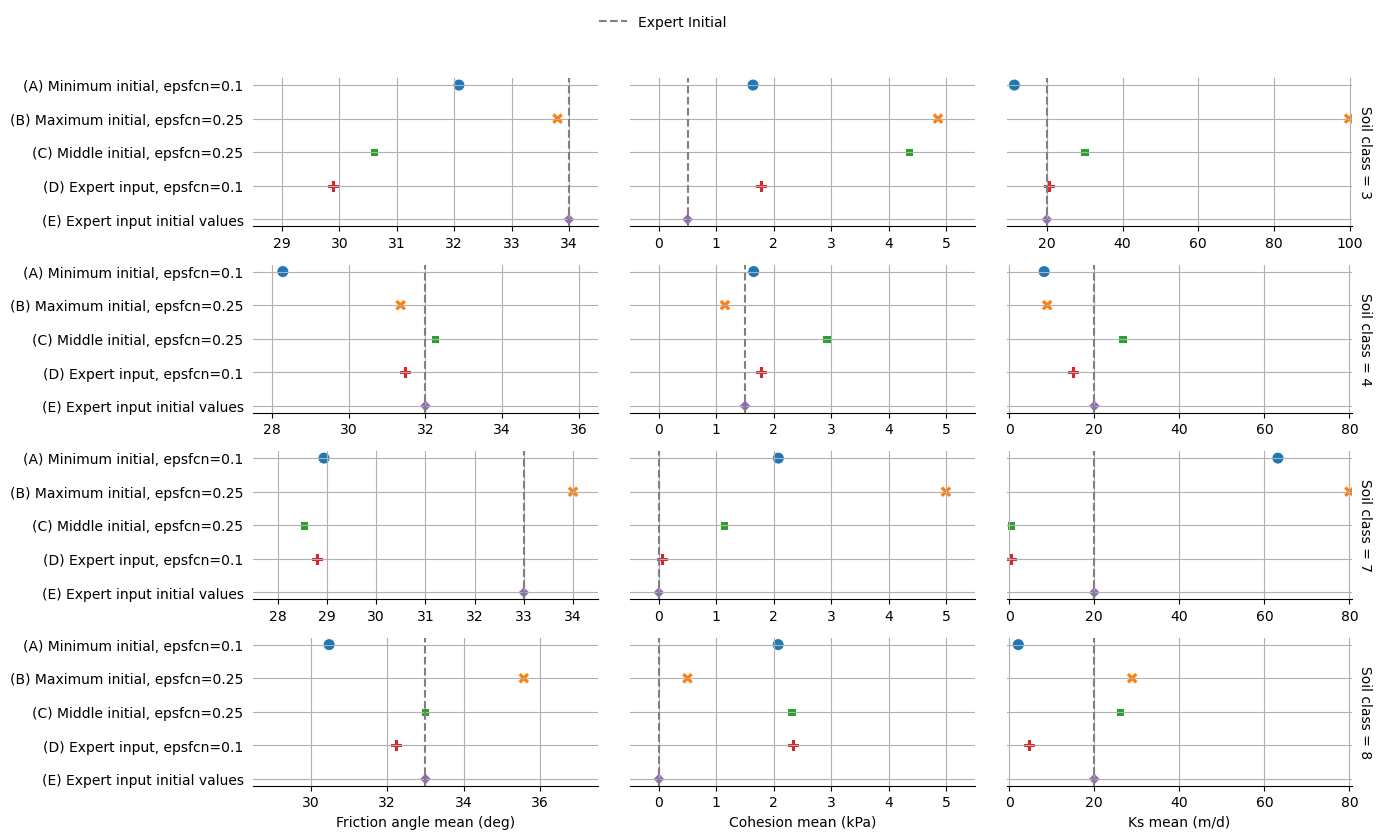

In [67]:
mlt = pd.melt(soil_properties_df[soil_properties_df["run"].isin(selected_runs)], id_vars=["run","iteration","Soil ID","i"], value_vars=["Friction angle mean (deg)","Cohesion mean (kPa)","Ks mean (m/d)"])
run_keys = list(run_labels.keys())
mlt["i"] = mlt["run"].apply(lambda x: run_keys.index(x))
mlt["run"] = mlt["run"].apply(lambda x: run_labels[x])

mlt.sort_values(by=["run","Soil ID"], inplace=True)


g = sns.relplot(data=mlt, x="value", y="run", hue="run", style="run", col="variable", row="Soil ID", s=75, facet_kws={"sharex":False,"margin_titles":True},height=2,aspect=2.5)
sns.despine(left=True)
g.set_titles(template = "", col_template = "", row_template = "Soil class = {row_name}")

for i in range(len(g.row_names)):
    for j in range(len(g.col_names)):
        ax = g.axes[i][j]
        var_symbol = var_mappings[g.col_names[j]]
        var_param = optimization_parameters["{0}_{1}".format(var_symbol,g.row_names[i])]
        min_val = var_param["min"] -0.5
        max_val = var_param["max"] +0.5
        init_val = var_param["value"]
        
        ax.set_xlim(min_val,max_val)
        axln = ax.axvline(x=init_val, color="gray", linestyle='--')

for ax in g.axes.flatten():
    ax.set(xlabel="",ylabel="")
    ax.grid(True, axis='both')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(left=False)

for i in range(len(g.axes[0])):
    ax = g.axes[3][i]
    ax.set(xlabel=g.col_names[i])

g._legend.remove()

leg = plt.legend(handles=[axln], labels=["Expert Initial"], loc="upper center", bbox_to_anchor=(-1, 5.3), frameon=False)

# plt.show()

g.savefig("fig6.png", dpi=600)
g.savefig("fig6.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
g.savefig("fig6.eps", dpi=600)


Distribution of AUC values.

In [68]:
optimization_runs = {
    # "Expert input initial values": {"path": "./data/optimization/expert_default","selection":np.min},
    "Expert input, epsfcn=0.1": {"path": "./data/optimization/expert_0_1","selection":np.max},
    # "Expert input, epsfcn=0.25": {"path": "./data/optimization/expert_0_25","selection":np.max},
    # "Expert input, epsfcn=0.5": {"path": "./data/optimization/expert_0_5","selection":np.max},
    # "Expert input, epsfcn=0.75": {"path": "./data/optimization/expert_0_75","selection":np.max},
    "Minimum initial, epsfcn=0.1": {"path": "./data/optimization/minimum_0_1","selection":np.max},
    # "Minimum initial, epsfcn=0.25": {"path": "./data/optimization/minimum_0_25","selection":np.max},    
    "Middle initial, epsfcn=0.25": {"path": "./data/optimization/middle_0_25","selection":np.max},    
    # "Maximum initial, epsfcn=0.1": {"path": "./data/optimization/maximum_0_1","selection":np.max},
    "Maximum initial, epsfcn=0.25": {"path": "./data/optimization/maximum_0_25","selection":np.max},
}

optimization_base_path = "./data/optimization/expert_default"
csv_path = os.path.join(optimization_base_path,"optimization_merged_1.csv")
iteration = 1
opt_initial_df = pd.read_csv(csv_path)
opt_initial_df = opt_initial_df.iloc[:,1:]
opt_initial_df["iteration"] = iteration
opt_initial_df["sensitivity"] = opt_initial_df["plot_fid"].apply(lambda x: x in psid_sensitivity)
opt_initial_df["Group"] = opt_initial_df["sensitivity"].apply(lambda x: "With landslides" if x else "Without landslides")
opt_initial_df["state"] = "Initial (Expert input)"
opt_initial_df["run"] = "Expert input initial values"

opt_dfs = []
i = 0
for key in optimization_runs:
    run = optimization_runs[key]
    optimization_base_path = run["path"]
    iterations = []
    for csv_path in glob.glob(os.path.join(optimization_base_path,"SoilProperties_*.csv")):
        csv_name = os.path.basename(csv_path)
        iteration = int(csv_name.replace("SoilProperties_","").replace(".csv",""))
        iterations.append(iteration)
    
    iteration = min(iterations)
    csv_path = os.path.join(optimization_base_path,"optimization_merged_{0}.csv".format(iteration))
    optt_min_df = pd.read_csv(csv_path)
    optt_min_df = optt_min_df.iloc[:,1:]
    optt_min_df["iteration"] = iteration
    optt_min_df["state"] = "Initial"
    optt_min_df["same"] = True
    optt_min_df["run"] = key 
    opt_dfs.append(optt_min_df)

    iteration = max(iterations)
    csv_path = os.path.join(optimization_base_path,"optimization_merged_{0}.csv".format(iteration))
    optt_max_df = pd.read_csv(csv_path)
    optt_max_df = optt_max_df.iloc[:,1:]
    optt_max_df["iteration"] = iteration
    optt_max_df["state"] = "Optimised"
    optt_max_df["same"] = True
    optt_max_df["run"] = key
    opt_dfs.append(optt_max_df)

    opt_same_df = pd.concat([optt_min_df.reset_index(),optt_max_df.reset_index()])
    opt_same_df["Group"] = "All"
    opt_dfs.append(opt_same_df)

    optt_min_copy_df = opt_initial_df.reset_index()
    optt_min_copy_df["same"] = False
    optt_min_copy_df["run"] = key
    opt_dfs.append(optt_min_copy_df)
    
    optt_max_copy_df = optt_max_df.reset_index()
    optt_max_copy_df["same"] = False
    opt_dfs.append(optt_max_copy_df)

    opt_diff_df = pd.concat([optt_min_copy_df.reset_index(),optt_max_copy_df.reset_index()])
    opt_diff_df["Group"] = "All"
    opt_dfs.append(opt_diff_df)
    
opt_df = pd.concat(opt_dfs)
opt_df["sensitivity"] = opt_df["plot_fid"].apply(lambda x: x in psid_sensitivity)
opt_df["Group"] = opt_df.apply(lambda x: x["Group"] if x["Group"] == "All" else "With landslides" if x["sensitivity"] else "Without landslides", axis=1)
opt_df =  opt_df.sort_values(by=["Group","state"], ascending=True)

opt_df["run"] = opt_df["run"].apply(lambda x: run_labels[x])

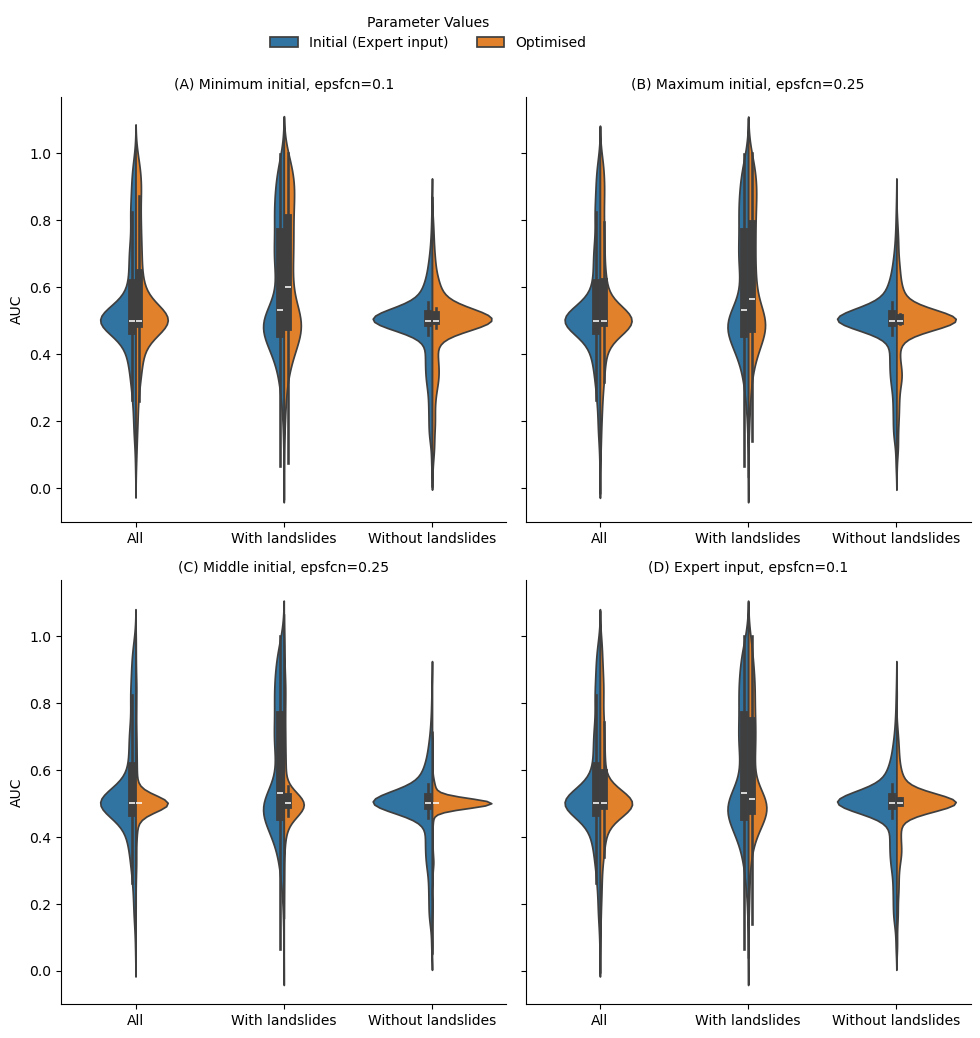

In [69]:
df = opt_df[np.invert(opt_df["same"])].reset_index(drop=True)
df.sort_values(by=["run","Group"], inplace=True)

g = sns.catplot(data=df, y="auc", x="Group", hue="state", 
                col="run", col_wrap=2, 
                kind="violin", split=True, sharex=False, sharey=True) 

g.set_titles(col_template="{col_name}")
g.set(ylabel="AUC",xlabel="")
sns.move_legend(g, "lower center", bbox_to_anchor=(.375, 1), 
                ncol=3, title="Parameter Values", frameon=False)

# for ax in g.axes[1:]:
#     sns.despine(ax=ax, left=True)
#     ax.set_yticks([])
#     ax.set(ylabel="")

# plt.subplots_adjust(wspace=0.1)

g.savefig("fig5.png", dpi=600) 
g.savefig("fig5.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
g.savefig("fig5.eps", dpi=600) 

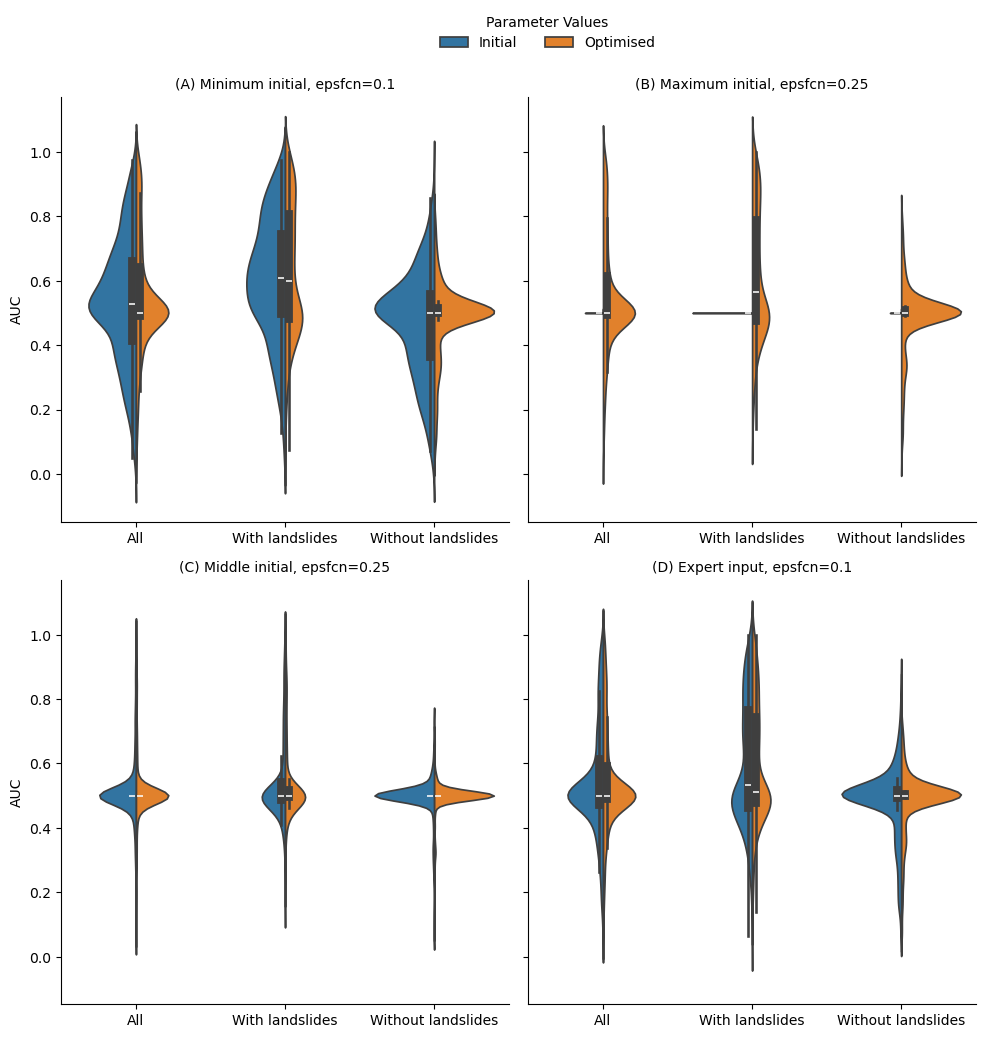

In [70]:
df = opt_df[opt_df["same"]].reset_index(drop=True)
df.sort_values(by=["run","Group"], inplace=True)


g = sns.catplot(data=df, y="auc", x="Group", hue="state", 
                col="run", col_wrap=2, 
                kind="violin", split=True, sharex=False, sharey=True) 

g.set_titles(col_template="{col_name}")
g.set(ylabel="AUC",xlabel="")
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title="Parameter Values", frameon=False)

g.savefig("fig10.png", dpi=600) 
g.savefig("fig10.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
g.savefig("fig10.eps", dpi=600) 

[0.37360496 0.46613537 0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.50810098 0.5720502  0.67892004
 0.82559082 0.99990404]


i       auc       res  plot_fid  iteration      state  same  \
2241  155  0.052612  0.947388     19126        155  Optimised  True   
4718  155  0.052612  0.947388     19126        155  Optimised  True   
2237  155  0.091884  0.908116     19056        155  Optimised  True   
4716  155  0.091884  0.908116     19056        155  Optimised  True   
1429  155  0.108598  0.891402      3885        155  Optimised  True   
...   ...       ...       ...       ...        ...        ...   ...   
3306  155  0.990407  0.009593      9599        155  Optimised  True   
1685  155  0.995286  0.004714      9464        155  Optimised  True   
3300  155  0.995286  0.004714      9464        155  Optimised  True   
3578  155  0.999904  0.000096     18026        155  Optimised  True   
2188  155  0.999904  0.000096     18026        155  Optimised  True   

                                   run   index               Group  \
2241  (B) Maximum initial, epsfcn=0.25  1025.0                 All   
4718  (B) Maximum initial, epsfcn=0.25     NaN  Without landslides   
2237  (B) Maximum initial, epsfcn=0.25  1021.0                 All   
4716  (B) Maximum initial, epsfcn=0.25     NaN  Without landslides   
1429  (B) Maximum initial, epsfcn=0.25   213.0                 All   
...                                ...     ...                 ...   
3306  (B) Maximum initial, epsfcn=0.25     NaN     With landslides   
1685  (B) Maximum initial, epsfcn=0.25   469.0                 All   
3300  (B) Maximum initial, epsfcn=0.25     NaN     With landslides   
3578  (B) Maximum initial, epsfcn=0.25     NaN     With landslides   
2188  (B) Maximum initial, epsfcn=0.25   972.0                 All   

      sensitivity  level_0  
2241        False      NaN  
4718        False      NaN  
2237        False      NaN  
4716        False      NaN  
1429        False      NaN  
...           ...      ...  
3306         True      NaN  
1685         True      NaN  
3300         True      NaN  
3578         True      NaN  
2188         True      NaN  

[4864 rows x 12 columns]

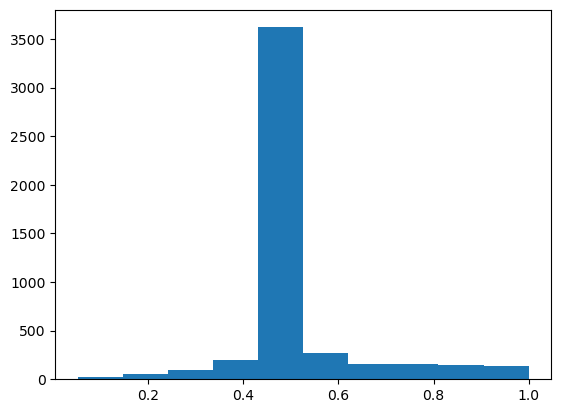

In [71]:
df = opt_df[opt_df["same"] & (opt_df["run"]=='(B) Maximum initial, epsfcn=0.25')].reset_index(drop=True)
df.sort_values(by=["auc"], inplace=True)
print(np.percentile(df.auc,[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]))
plt.hist(df.auc)
df



<a id="#Application"></a>
## Application

In [72]:
application_base_path = "./data/application"

In [73]:
ezg_labels = {111731:"Jura", 102117:"Central Plateau", 107220:"Pre-Alps", 103925:"Alps"}
ezg_keys = list(ezg_labels.keys())
sim_labels = {"maximum_0_25":"(A) Maximum initial optimised, epsfcn=0.25", "minimum_0_1":"(B) Minimum initial optimised, epsfcn=0.1", "expert_initial":"(E) Expert input initial values","expert_0_1":"(D) Expert input optimised, epsfcn=0.1"}
variant_labels = {"hectare": "Hectares", "process_source": "Microcatchments", "catchment":"Catchment"}


In [74]:
auc_all_dfs = []

for folder_name in next(os.walk(application_base_path))[1]:
    for csv_path in glob.glob(os.path.join(application_base_path,folder_name,"**","auc_all_catchment.csv")):
        csv_name = os.path.basename(csv_path)
        variant = csv_name.replace("auc_all_","").replace(".csv","")
        auct_df = pd.read_csv(csv_path)

        ezg_name = folder_name
        ezg_id = int(ezg_name.replace("catchment_",""))
        auct_df["ezg"] = ezg_name
        auct_df["ezgnr"] = ezg_id
        auct_df["ezg_label"] = ezg_labels[ezg_id]
        auct_df["variant"] = variant
        
        # auct_df = auct_df.iloc[:,1:]
        auc_all_dfs.append(auct_df)
    
auc_df = pd.concat(auc_all_dfs)

auc_df["sim_label"] = auc_df["sim"].apply(lambda x: sim_labels[x.replace("realistic","expert")])
auc_df["variant_label"] = auc_df["variant"].apply(lambda x: variant_labels[x])

auc_df["ezg_order"] = auc_df["ezgnr"].apply(lambda x: ezg_keys.index(x))


In [75]:
auc_slides_dfs = []

for folder_name in next(os.walk(application_base_path))[1]:
    for csv_path in glob.glob(os.path.join(application_base_path,folder_name,"**","auc_slides_*.csv")):
        csv_name = os.path.basename(csv_path)
        variant = csv_name.replace("auc_slides_","").replace(".csv","")
        auct_df = pd.read_csv(csv_path)

        ezg_name = folder_name
        ezg_id = int(ezg_name.replace("catchment_",""))
        auct_df["ezg"] = ezg_name
        auct_df["ezgnr"] = ezg_id
        auct_df["ezg_label"] = ezg_labels[ezg_id]
        auct_df["variant"] = variant
        # auct_df = auct_df.iloc[:,1:]
        auc_slides_dfs.append(auct_df)

auc_slides_df = pd.concat(auc_slides_dfs)

auc_slides_df["sim_label"] = auc_slides_df["sim"].apply(lambda x: sim_labels[x.replace("realistic","expert")])
auc_slides_df["variant_label"] = auc_slides_df["variant"].apply(lambda x: variant_labels[x])

auc_slides_df["ezg_order"] = auc_slides_df["ezgnr"].apply(lambda x: ezg_keys.index(x))


In [76]:
prob_slides_dfs = []

for folder_name in next(os.walk(application_base_path))[1]:
    for csv_path in glob.glob(os.path.join(application_base_path,folder_name,"**","prob50_slide_*.csv")):
        csv_name = os.path.basename(csv_path)
        variant = csv_name.replace("prob50_slide_","").replace(".csv","")

        sim_path = os.path.dirname(csv_path)
        sim = os.path.basename(sim_path)
        
        csv_name = os.path.basename(csv_path)
        sldt_df = pd.read_csv(csv_path)

        ezg_name = folder_name
        ezg_id = int(ezg_name.replace("catchment_",""))
        sldt_df["ezg"] = ezg_name
        sldt_df["ezgnr"] = ezg_id
        sldt_df["ezg_label"] = ezg_labels[ezg_id]
        sldt_df["sim"] = sim
        sldt_df["variant"] = variant
        # auct_df = auct_df.iloc[:,1:]
        prob_slides_dfs.append(sldt_df)

prob50_slides_df = pd.concat(prob_slides_dfs)
prob50_slides_df["prob_slide_mod"] = prob50_slides_df["n"]/62

prob50_slides_df["prob_slide_round"] = prob50_slides_df["prob_slide"].apply(lambda x: round(x,4))
prob50_slides_df["prob_slide_mod_round"] = prob50_slides_df["prob_slide_mod"].apply(lambda x: round(x,4))
prob50_slides_df["sim_label"] = prob50_slides_df["sim"].apply(lambda x: sim_labels[x])
prob50_slides_df["variant_label"] = prob50_slides_df["variant"].apply(lambda x: variant_labels[x])

prob50_slides_df["ezg_order"] = prob50_slides_df["ezgnr"].apply(lambda x: ezg_keys.index(x))
prob50_slides_df.reset_index(inplace=True)


In [77]:
prob_slides_dfs = []

for folder_name in next(os.walk(application_base_path))[1]:
    for csv_path in glob.glob(os.path.join(application_base_path,folder_name,"**","prob100_slide_*.csv")):
        csv_name = os.path.basename(csv_path)
        variant = csv_name.replace("prob100_slide_","").replace(".csv","")

        sim_path = os.path.dirname(csv_path)
        sim = os.path.basename(sim_path)
        
        csv_name = os.path.basename(csv_path)
        sldt_df = pd.read_csv(csv_path)

        ezg_name = folder_name
        ezg_id = int(ezg_name.replace("catchment_",""))
        sldt_df["ezg"] = ezg_name
        sldt_df["ezgnr"] = ezg_id
        sldt_df["ezg_label"] = ezg_labels[ezg_id]
        sldt_df["sim"] = sim
        sldt_df["variant"] = variant
        # auct_df = auct_df.iloc[:,1:]
        prob_slides_dfs.append(sldt_df)

prob100_slides_df = pd.concat(prob_slides_dfs)
prob100_slides_df["prob_slide_mod"] = prob100_slides_df["n"]/62

prob100_slides_df["prob_slide_round"] = prob100_slides_df["prob_slide"].apply(lambda x: round(x,4))
prob100_slides_df["prob_slide_mod_round"] = prob100_slides_df["prob_slide_mod"].apply(lambda x: round(x,4))
prob100_slides_df["sim_label"] = prob100_slides_df["sim"].apply(lambda x: sim_labels[x])
prob100_slides_df["variant_label"] = prob100_slides_df["variant"].apply(lambda x: variant_labels[x])

prob100_slides_df["ezg_order"] = prob100_slides_df["ezgnr"].apply(lambda x: ezg_keys.index(x))
prob100_slides_df.reset_index(inplace=True)


In [78]:
csv_path = os.path.join(application_base_path,"variant_stats.csv")
csv_name = os.path.basename(csv_path)
variant_stats_df = pd.read_csv(csv_path)

variant_stats_df["ezgnr"] = variant_stats_df["ezg"].apply(lambda x: int(x.replace("ezg_","")))
variant_stats_df["ezg_label"] = variant_stats_df["ezgnr"].apply(lambda x: ezg_labels[x])
variant_stats_df = variant_stats_df[np.invert(variant_stats_df["sim"].isin(["nelder-mead_initial","realistic_0_25"]))].reset_index(drop=True)

variant_stats_df["sim_label"] = variant_stats_df["sim"].apply(lambda x: sim_labels[x.replace("realistic","expert")])
variant_stats_df["variant_label"] = variant_stats_df["name"].apply(lambda x: variant_labels[x])

variant_stats_df["ezg_order"] = variant_stats_df["ezgnr"].apply(lambda x: ezg_keys.index(x))


In [79]:
df = auc_df.sort_values(by=["sim_label","ezg_order"])
df.pivot(index=["sim_label"], columns=["ezg_label","ezg_order"], values="auc").round(3)


ezg_label                                    Jura Central Plateau Pre-Alps  \
ezg_order                                       0               1        2   
sim_label                                                                    
(A) Maximum initial optimised, epsfcn=0.25  0.630           0.778    0.808   
(B) Minimum initial optimised, epsfcn=0.1   0.680           0.805    0.813   
(D) Expert input optimised, epsfcn=0.1      0.587           0.745    0.768   
(E) Expert input initial values             0.730           0.733    0.780   

ezg_label                                    Alps  
ezg_order                                       3  
sim_label                                          
(A) Maximum initial optimised, epsfcn=0.25  0.814  
(B) Minimum initial optimised, epsfcn=0.1   0.822  
(D) Expert input optimised, epsfcn=0.1      0.793  
(E) Expert input initial values             0.794

In [80]:
df = variant_stats_df.reset_index()
df["sum"] = df["sum"].round(2)
df["correction_factor"] = df["correction_factor"].round(6)
df = df.sort_values(by=["sim_label","variant_label","ezg_order"])

df.pivot(index=["sim_label","variant_label"], columns=["ezg_label","ezg_order"], values=["sum","correction_factor"])

sum  \
ezg_label                                                       Jura   
ezg_order                                                          0   
sim_label                                  variant_label               
(A) Maximum initial optimised, epsfcn=0.25 Catchment            3.59   
                                           Hectares           189.86   
                                           Microcatchments    867.49   
(B) Minimum initial optimised, epsfcn=0.1  Catchment            3.46   
                                           Hectares            86.44   
                                           Microcatchments    487.12   
(D) Expert input optimised, epsfcn=0.1     Catchment            4.03   
                                           Hectares          3132.75   
                                           Microcatchments  84073.06   
(E) Expert input initial values            Catchment            3.59   
                                           Hectares           128.42   
                                           Microcatchments    137.47   

                                                                            \
ezg_label                                                  Central Plateau   
ezg_order                                                                1   
sim_label                                  variant_label                     
(A) Maximum initial optimised, epsfcn=0.25 Catchment                175.20   
                                           Hectares                 900.32   
                                           Microcatchments          337.77   
(B) Minimum initial optimised, epsfcn=0.1  Catchment                178.32   
                                           Hectares                 974.20   
                                           Microcatchments          335.81   
(D) Expert input optimised, epsfcn=0.1     Catchment                183.18   
                                           Hectares                 896.99   
                                           Microcatchments          419.73   
(E) Expert input initial values            Catchment                182.24   
                                           Hectares                1313.05   
                                           Microcatchments          505.43   

                                                                             \
ezg_label                                                  Pre-Alps    Alps   
ezg_order                                                         2       3   
sim_label                                  variant_label                      
(A) Maximum initial optimised, epsfcn=0.25 Catchment          35.73   38.10   
                                           Hectares          418.14  717.03   
                                           Microcatchments   254.12  170.63   
(B) Minimum initial optimised, epsfcn=0.1  Catchment          36.35   38.88   
                                           Hectares          440.10  786.55   
                                           Microcatchments   249.38  187.15   
(D) Expert input optimised, epsfcn=0.1     Catchment          31.21   35.95   
                                           Hectares          230.26  814.56   
                                           Microcatchments   331.57  186.67   
(E) Expert input initial values            Catchment          33.17   37.02   
                                           Hectares          301.86  950.80   
                                           Microcatchments   260.36  192.92   

                                                           correction_factor  \
ezg_label                                                               Jura   
ezg_order                                                                  0   
sim_label                                  variant_label                       
(A) Maximum initial optimised, epsfcn=0.25 Catchment                0.000480  

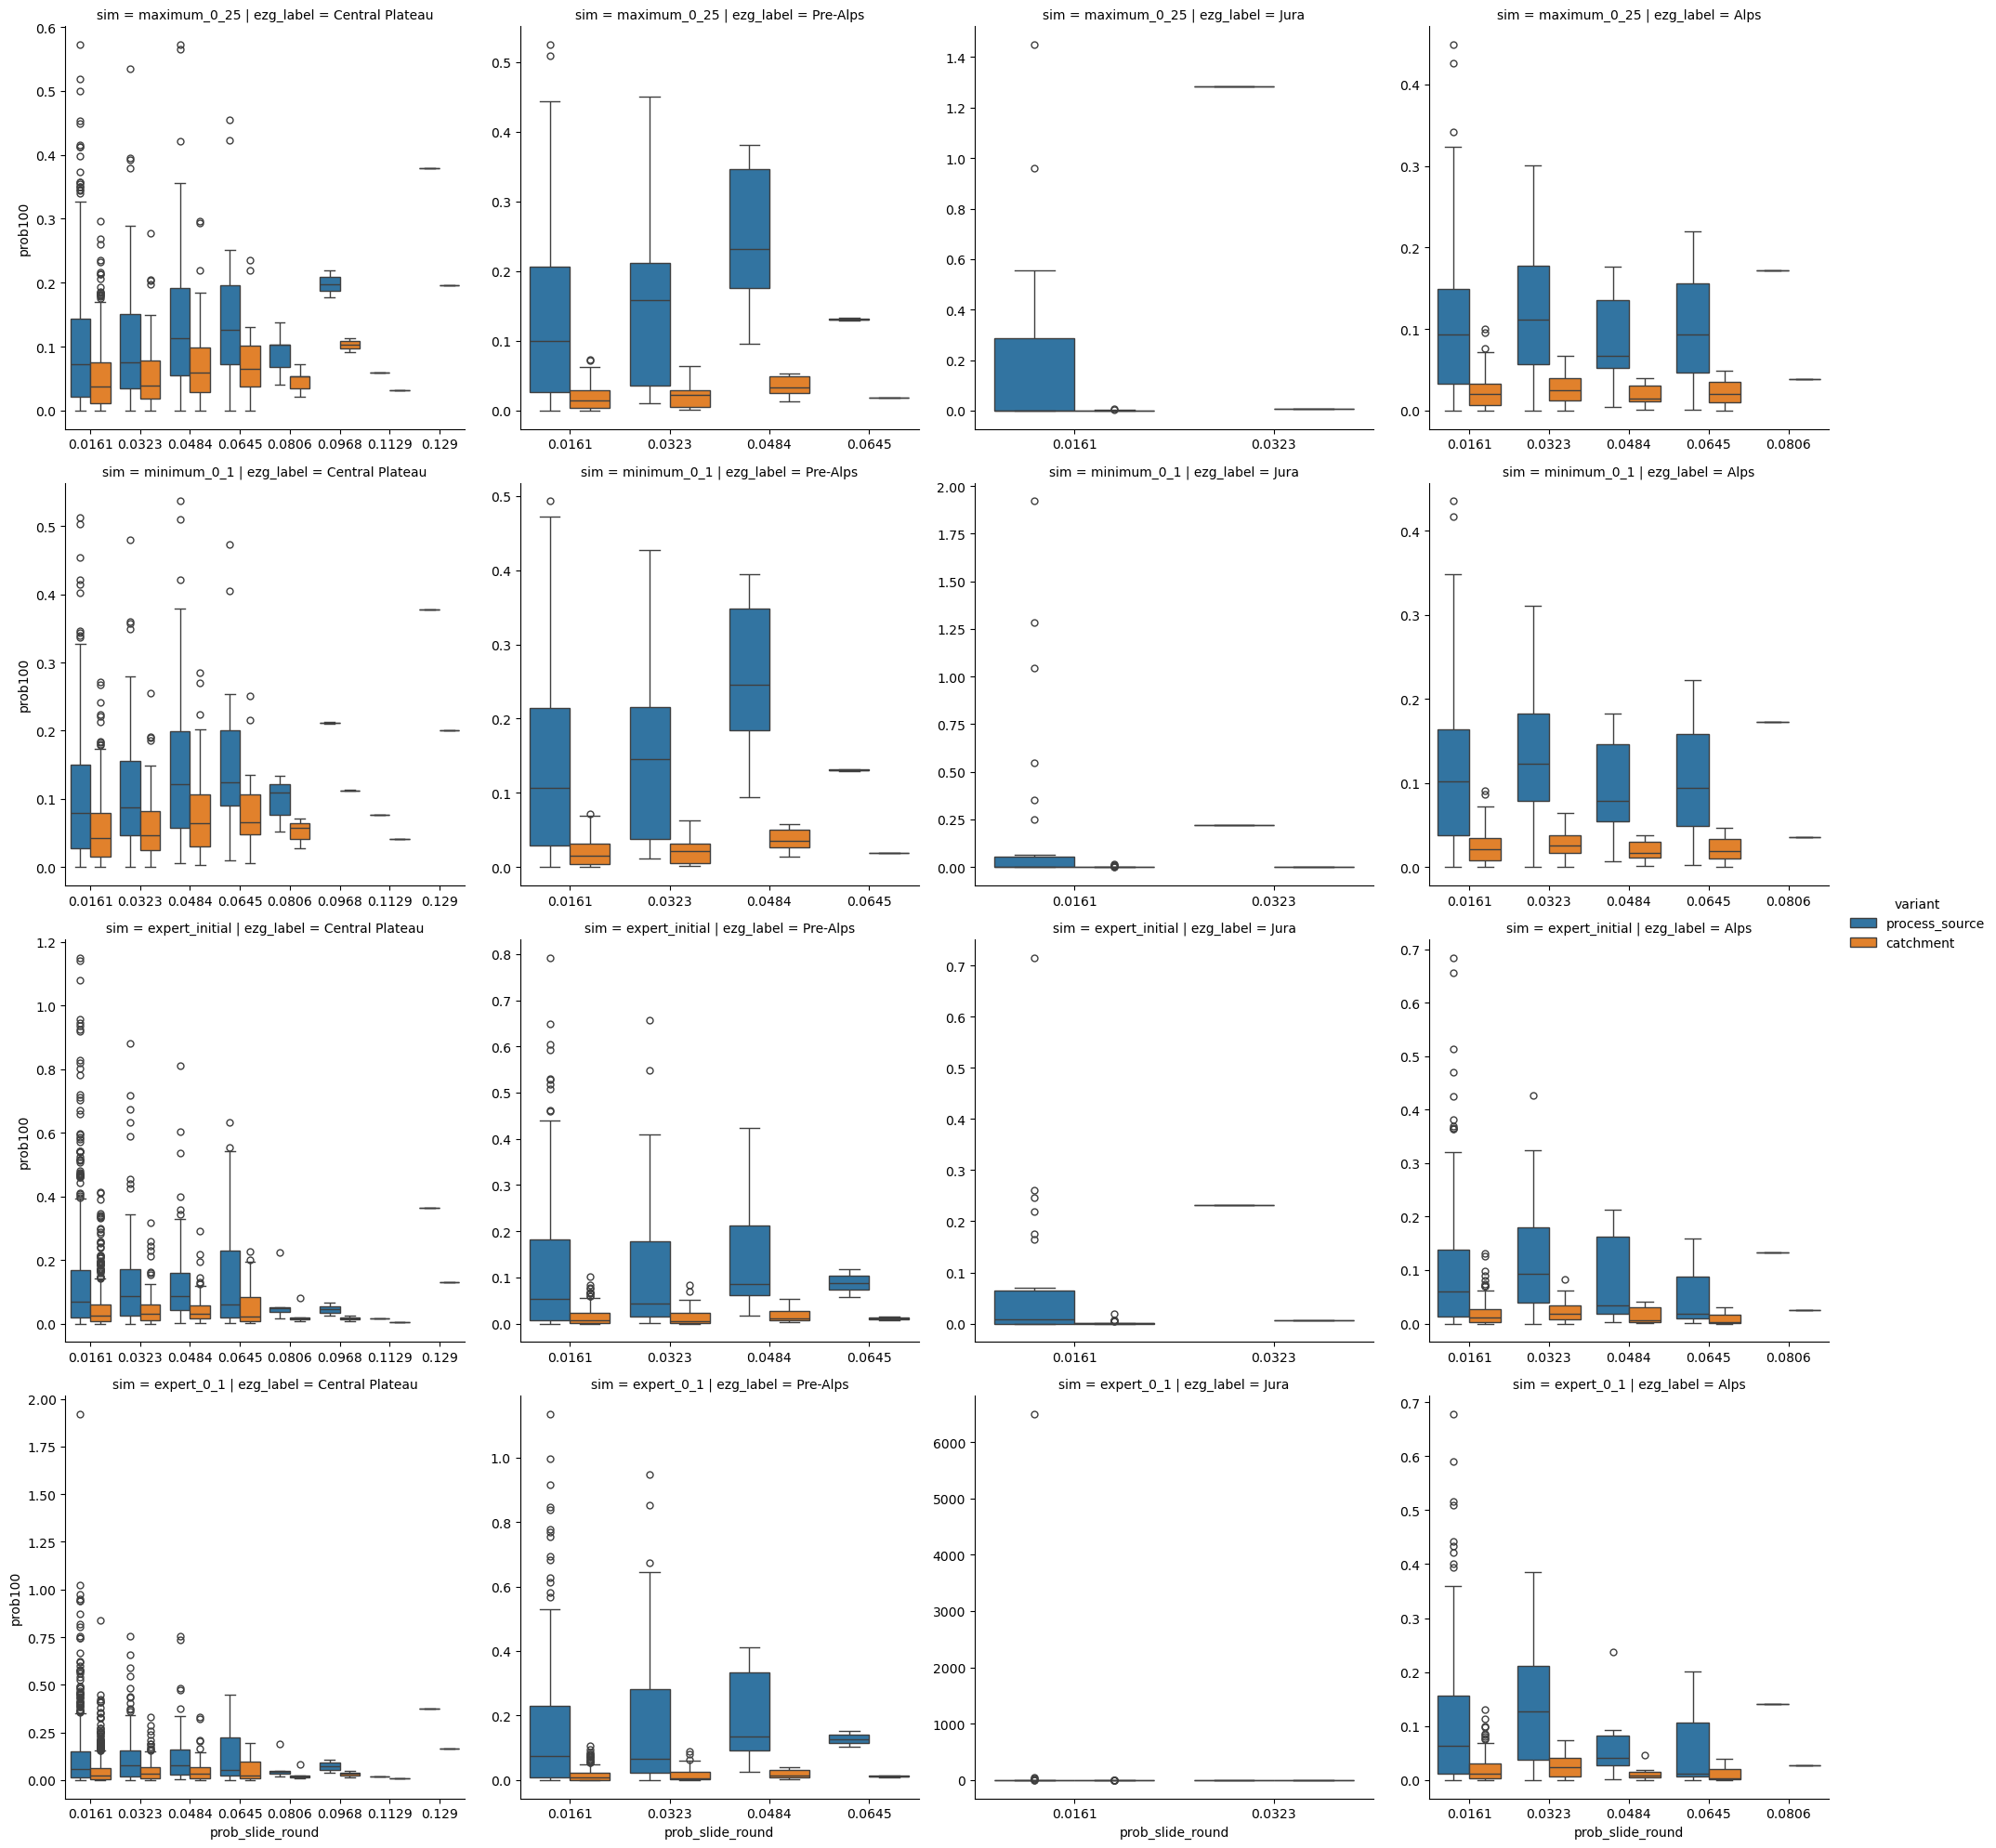

In [81]:
g = sns.catplot(data=prob100_slides_df[(prob100_slides_df["n"]>0)&(prob100_slides_df["variant"].isin(["catchment","process_source"]))], x="prob_slide_round", y="prob100",hue="variant",col="ezg_label",  kind="box", row="sim", sharex=False,sharey=False )

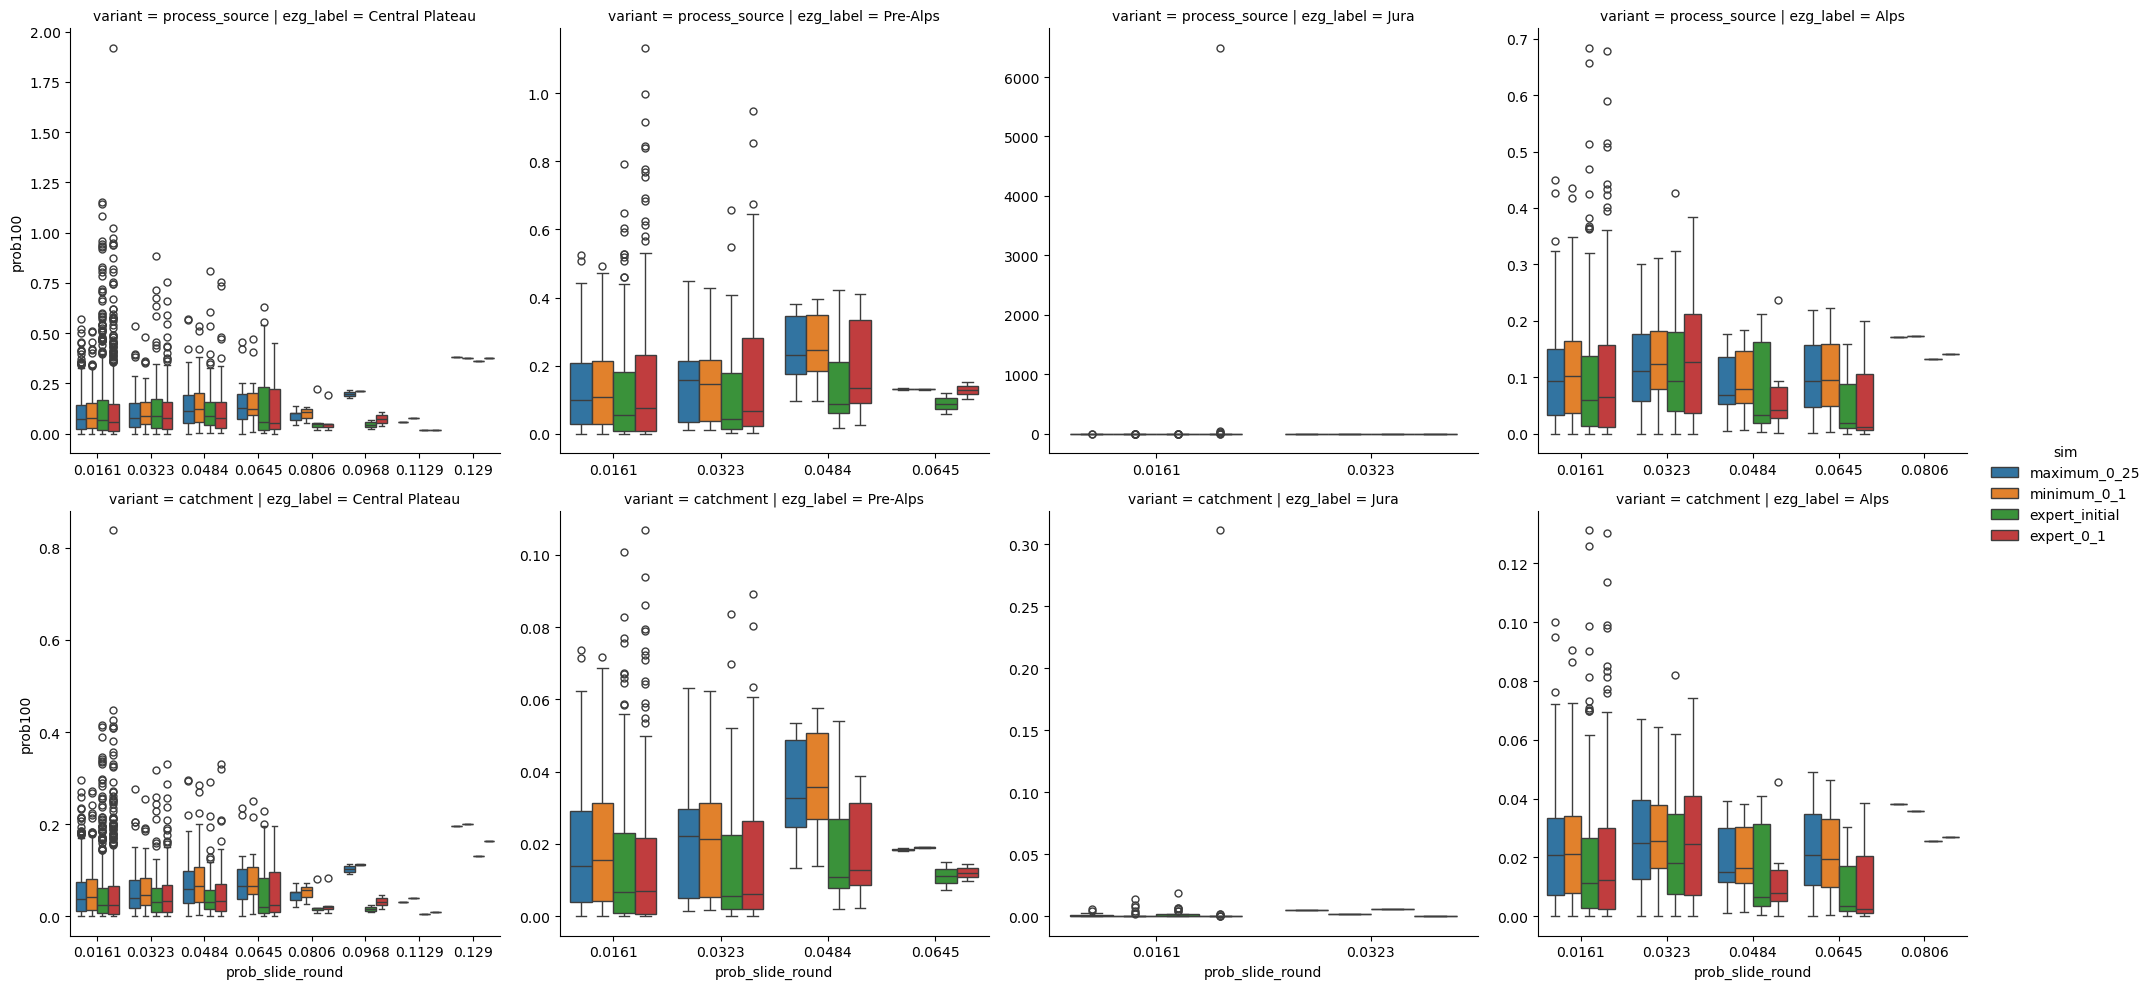

In [82]:
g = sns.catplot(data=prob100_slides_df[(prob100_slides_df["n"]>0)&(prob100_slides_df["variant"].isin(["catchment","process_source"]))], x="prob_slide_round", y="prob100",hue="sim",col="ezg_label",  kind="box", row="variant", sharex=False,sharey=False )

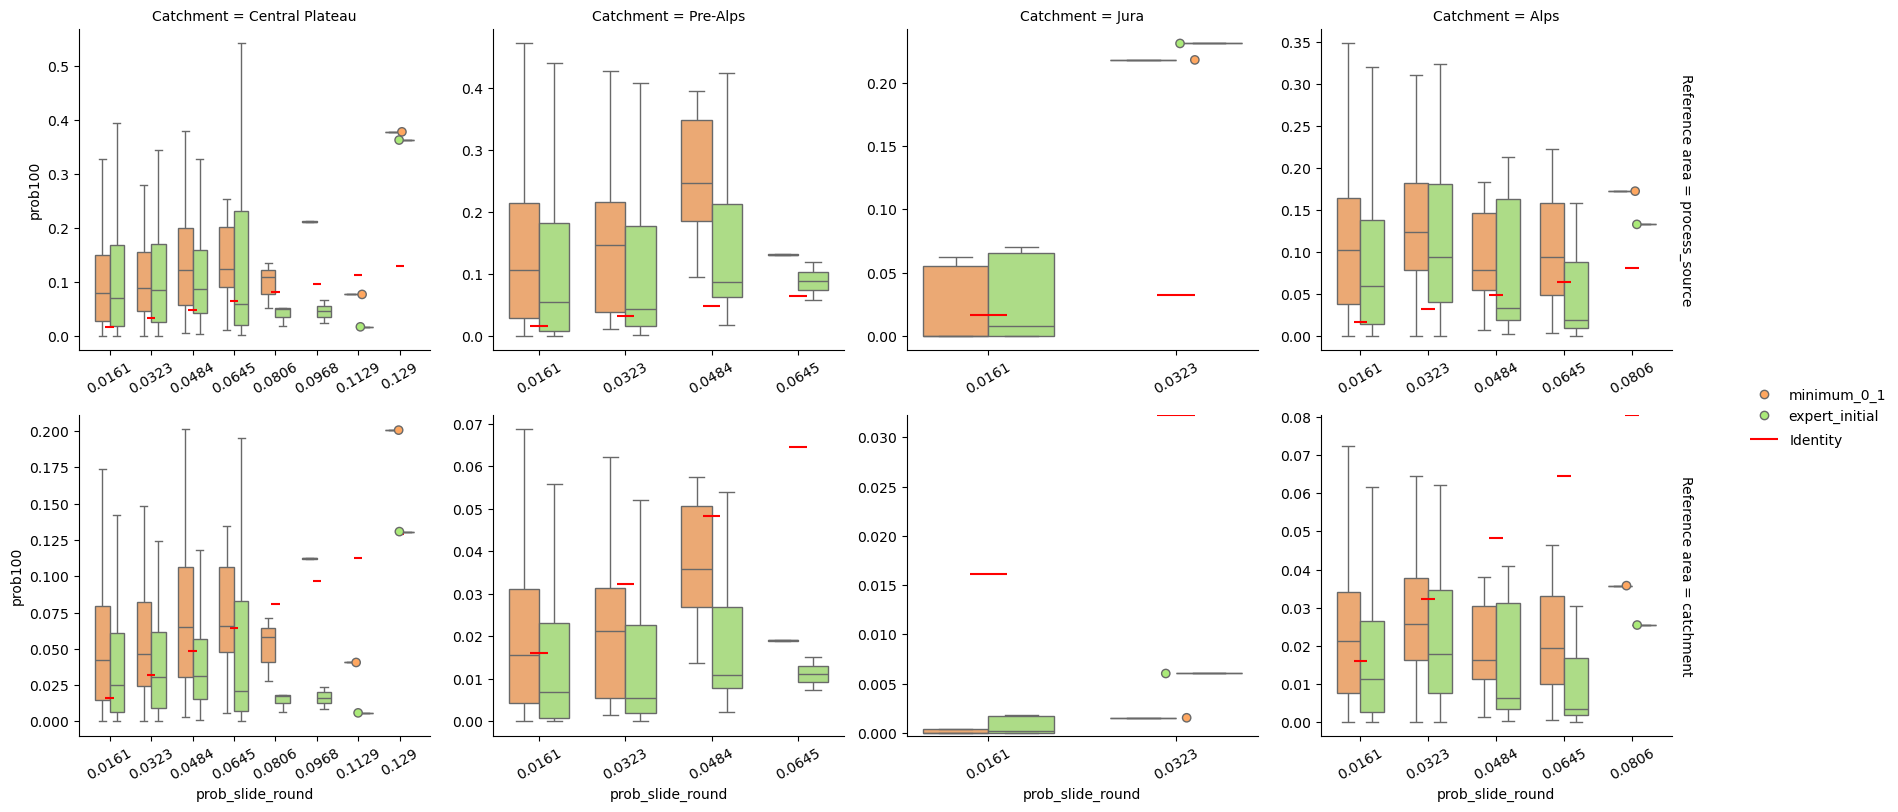

In [83]:
df = prob100_slides_df[(prob100_slides_df["n"]>0)&(prob100_slides_df["variant"].isin(["catchment","process_source"]))&(prob100_slides_df["sim"].isin(["minimum_0_1","expert_initial"]))].reset_index()
g = sns.FacetGrid(df, col="ezg_label", row="variant", sharex=False,sharey=False, margin_titles=True, height=4,aspect=1.1)

def semi_boxplot(data, x, y,hue, thresh=3, **kwargs):
    m = data.groupby(x).transform("size").ge(thresh)
    ax = sns.boxplot(x=data[x], y=data[y], hue=data[hue], showfliers=False,palette=["#FFA760", "#ABEA79"], **kwargs)
    ylim = ax.get_ylim()
    sns.stripplot(x=data[x], y=data[y].mask(m), hue=data[hue], ax=ax, linewidth=1, size=6,palette=["#FFA760", "#ABEA79"])
    ax.set_ylim(ylim[0],max(ylim[1],float(ax.get_xticklabels()[-1].get_text())))
    return ax

# semi_boxplot(data, x='days', y='error', zorder=4, color='powderblue', width=0.7)
g.map_dataframe(semi_boxplot,x="prob_slide_round", y="prob100", hue="sim", zorder=2, width=0.7)
g.add_legend()

# g = sns.catplot(data=df, x="prob_slide_round", y="prob100",hue="sim",col="ezg_label",  kind="box", row="variant", sharex=False,sharey=True, showfliers = False )
# g.map_dataframe(sns.pointplot, x="prob_slide_round", y="prob_slide_round", linestyle="", color="red", marker="_", markersize=10)
# g.add_legend()
for ax in g.axes.flatten():
    for xl in ax.get_xticklabels(): 
        x = xl._x
        y = float(xl.get_text())
        axln = ax.hlines(y=y, xmin=x-0.1, xmax=x+0.1, color="red")
leg = plt.legend(handles=[axln], labels=["Identity"], loc="center right", bbox_to_anchor=(1.522, 0.92), frameon=False)


# Set column and row titles for grid
g.set_titles(template = "", col_template = "Catchment = {col_name}", row_template = "Reference area = {row_name}")

# Make x-axis labels more legible
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace=0.2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


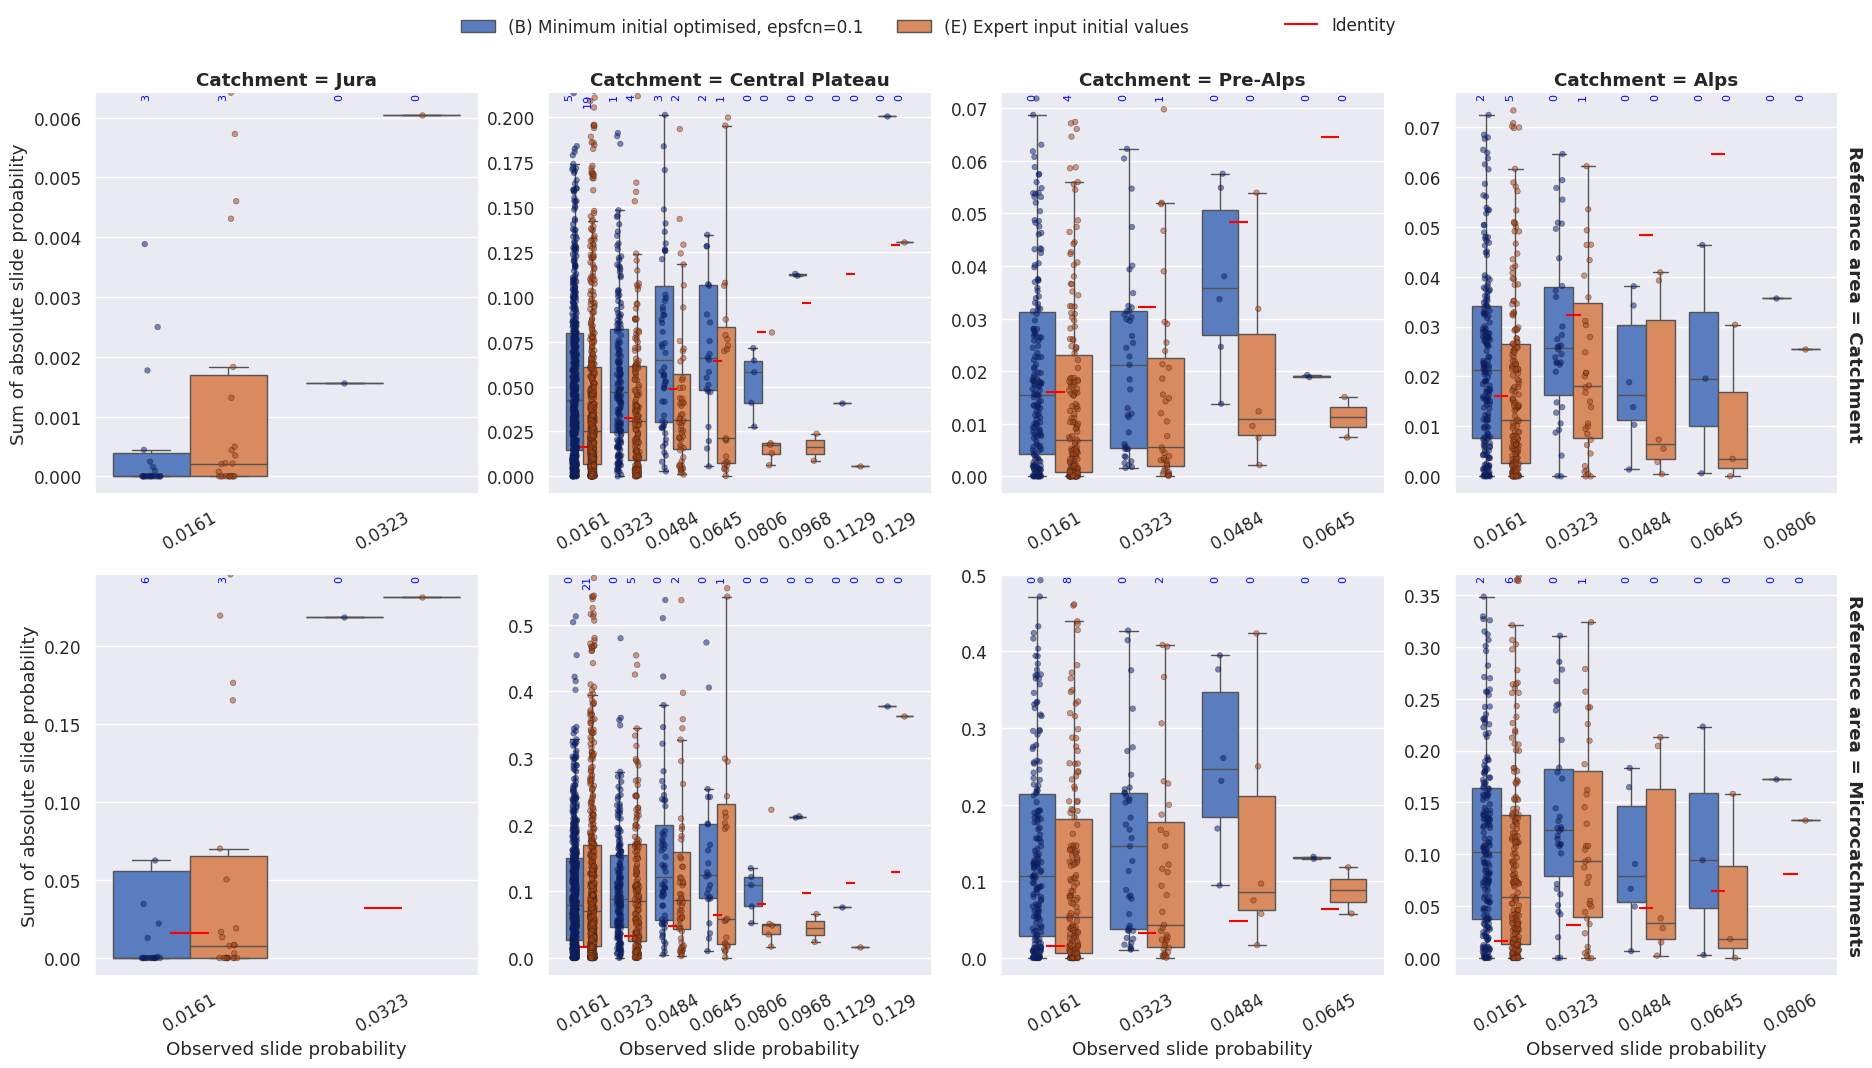

In [84]:
df = prob100_slides_df[(prob100_slides_df["n"]>0)&(prob100_slides_df["variant"].isin(["catchment","process_source"]))&(prob100_slides_df["sim"].isin(["minimum_0_1","expert_initial"]))].reset_index()

df.sort_values(by=["sim_label", "variant_label", "ezg_order"],inplace=True)
sns.set(font_scale=1.1)

# g = sns.catplot(data=df, x="prob_slide_round", y="prob100",hue="sim",col="ezg_label",  kind="box", row="variant", sharex=False,sharey=False, showfliers = False,palette=["#FFA760", "#ABEA79"], margin_titles=True, legend=True )
g = sns.catplot(data=df, x="prob_slide_round", y="prob100",hue="sim_label",col="ezg_label",  kind="box", row="variant_label", sharex=False,sharey=False, showfliers = False,palette=sns.color_palette("muted",2), margin_titles=True, legend=True )

# Save y-axis limits for later "restore"
box_ylim = [ax.get_ylim() for ax in g.axes.flatten()]
# g.map_dataframe(sns.stripplot, x="prob_slide_round", y="prob100",hue="sim",palette=sns.color_palette("dark",2),marker="$\circ$",facecolors="none",linewidth=0.5,alpha=0.5,size=4,dodge=True)
g.map_dataframe(sns.stripplot, x="prob_slide_round", y="prob100",hue="sim_label",palette=sns.color_palette("dark",2),facecolors="none",linewidth=0.5,alpha=0.5,size=4,dodge=True)

sns.color_palette("tab10")
# Restore y-axix limits after sprip plot has reset them
for (lim,ax) in zip(box_ylim,g.axes.flatten()):
    ax.set_ylim(lim[0],lim[1]+0.01*lim[1])

# Add "identity" point
# g.map_dataframe(sns.pointplot, x="prob_slide_round", y="prob_slide_round", linestyle="", color="red", marker="_", markersize=10)

for ax in g.axes.flatten():
    for xl in ax.get_xticklabels(): 
        x = xl._x
        y = float(xl.get_text())
        axln = ax.hlines(y=y, xmin=x-0.1, xmax=x+0.1, color="red")
        # hlines(y, xmin, xmax, colors=None, linestyles='solid', *, label='', data=None, **kwargs)

# Create/move legends
sns.move_legend( g, "lower center", bbox_to_anchor=(.35, 1), ncol=2, title="", frameon=False)
leg = plt.legend(handles=[axln], labels=["Identity"], loc="lower center", bbox_to_anchor=(-0.3, 2.31), frameon=False)

# Set column and row titles for grid
g.set_titles(template = "", col_template = "Catchment = {col_name}", row_template = "Reference area = {row_name}",weight='bold')

# Make x-axis labels more legible
g.set_xticklabels(rotation=30)
plt.subplots_adjust(hspace=0.2)

# set y-axis titles
for ax in g.axes[:,0]:
    ax.set(ylabel="Sum of absolute slide probability")

# set x-axis titles
for ax in g.axes[1,:]:
    ax.set(xlabel="Observed slide probability")

    

sns.set(font_scale=1)

# Function based on https://stackoverflow.com/a/74529022
def add_labels(ax, ax_data,  fmt = ".1f"):
    lines = ax.get_lines()

    sim_labels = ax_data["sim_label"].unique().tolist()
    sim_labels.sort()
    sim_nums = len(sim_labels)
    probs = ax_data["prob_slide_round"].unique().tolist()
    probs.sort()
    prob_nums = len(probs)
    
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    box_idx = 0
    for median in lines[start::lines_per_box]:
        # sim = sim_labels[box_idx%sim_nums]
        sim = sim_labels[box_idx//prob_nums]
        prob = probs[box_idx%prob_nums]

        y_lim=ax.get_ylim()[1]

        ax_selection = ax_data.loc[(ax_data["sim_label"]==sim)&
                                   (ax_data["prob_slide_round"]==prob)]
        box_stats = boxplot_stats(ax_selection["prob100"])
        n_outliers = len(box_stats[0]["fliers"])
        n_outliers = 0
        for val in box_stats[0]["fliers"]:
            if val>y_lim:
                n_outliers+=1
        
        x, y = (data.mean() for data in median.get_data())
        y = y_lim
        text = ax.text(x, y, f'{n_outliers}', rotation=90, fontsize=8,ha="right", va="top",color="blue",)
        # text = ax.text(x, y, f'{n_outliers}', rotation=90, fontsize=8,ha="right", va="top",color="white",)
        # text.set_path_effects([
        #     path_effects.Stroke(linewidth=3, foreground=median.get_color()),
        #     path_effects.Normal(),
        # ])
        box_idx+=1


for i in range(len(g.row_names)):
    for j in range(len(g.col_names)):
        ax = g.axes[i][j]
        df_selection = df.loc[(df["ezg_label"]==g.col_names[j])&
                              (df["variant_label"]==g.row_names[i])]
        add_labels(ax,df_selection)

g.savefig("fig8.png", dpi=600) 
g.savefig("fig8.tif", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"}) 
g.savefig("fig8.eps", dpi=300) 

